In [42]:
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.optim import AdamW
import torch
import time
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.nn.utils import clip_grad_norm_
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from scripts.preprocess_data import preprocess_dataset
from datasets import load_dataset, DatasetDict
from PIL import Image
from sklearn.metrics import accuracy_score
# Load pretrained CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
import torch
import time
import os
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import os
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, ReduceLROnPlateau
from tqdm import tqdm



In [43]:
# Load MIMIC-CXR dataset
# dataset = load_dataset("ChayanM/MIMIC-Impression-Dataset")

# Check and handle splitting
# if isinstance(dataset, DatasetDict):
#     if all(split in dataset for split in ["train", "val", "test"]):
#         train_dataset = dataset["train"]
#         val_dataset = dataset["val"]
#         test_dataset = dataset["test"]
#     elif all(split in dataset for split in ["train", "test"]):
#         # Create validation split from part of train
#         print("ℹ️ Found train/test, splitting validation from train...")
#         split_dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
#         train_dataset = split_dataset["train"]
#         val_dataset = split_dataset["test"]
#         test_dataset = dataset["test"]
#     else:
#         print("⚠️ Only one split found. Splitting into train/val/test manually...")
#         temp_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
#         val_test_split = temp_split["test"].train_test_split(test_size=0.5, seed=42)
#         train_dataset = temp_split["train"]
#         val_dataset = val_test_split["train"]
#         test_dataset = val_test_split["test"]
# else:
#     raise ValueError("Unexpected dataset format. Please check your dataset.")
# raw_dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset")
# print("Preprocessing dataset...")
# data_dir = "data/raw"
# preprocess_dataset(raw_dataset, output_dir=data_dir)
# print("Data preprocessing complete")

In [44]:
train_dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train[:80%]")
val_datset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train[80%:90%]")
test_dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train[90%:]")
train_dataset = train_dataset.filter(lambda x: x['impression'] is not None)
val_dataset = val_datset.filter(lambda x: x['impression'] is not None)
test_dataset = test_dataset.filter(lambda x: x['impression'] is not None)


In [45]:
print("train dataset:",train_dataset)
print("val dataset:", val_dataset)
print("test dataset:", test_dataset)

train dataset: Dataset({
    features: ['image', 'findings', 'impression'],
    num_rows: 24499
})
val dataset: Dataset({
    features: ['image', 'findings', 'impression'],
    num_rows: 3062
})
test dataset: Dataset({
    features: ['image', 'findings', 'impression'],
    num_rows: 3062
})


In [46]:
print("\n sample of train set",train_dataset[0])
print("\n sample of val set",val_dataset[0])
print("\n sample of test set",test_dataset[0])


 sample of train set {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x78BB70104880>, 'findings': 'The lungs are clear of focal consolidation, pleural effusion or pneumothorax. The heart size is normal. The mediastinal contours are normal. Multiple surgical clips project over the left breast, and old left rib fractures are noted. ', 'impression': 'No acute cardiopulmonary process.'}

 sample of val set {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x78BB70106290>, 'findings': 'Lung volumes are low. Mild interstitial pulmonary edema is present. Compared with prior chest radiograph there is a new confluent opacity in the right lower lung, obscuring some portions of the right hemidiaphragm margin. The left lung is clear. There may be a small layering pleural effusion in the right and chronic pleural thickening is redemonstrated. There is no evidence of pneumothorax. Severe S type scoliosis is again seen and not significantly chang

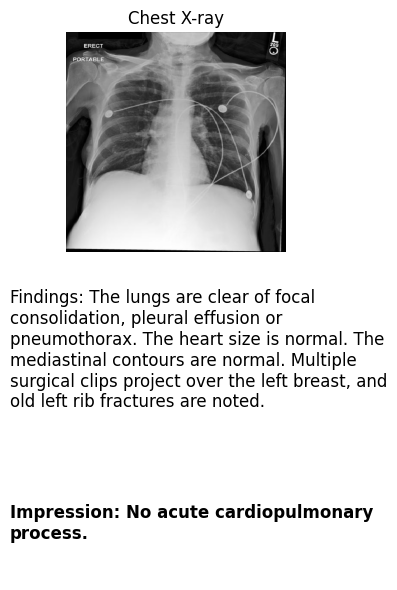

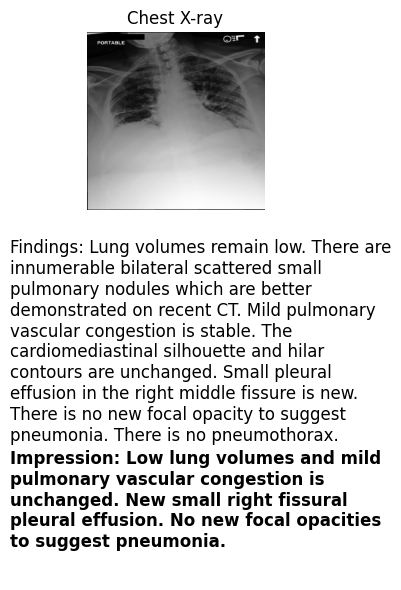

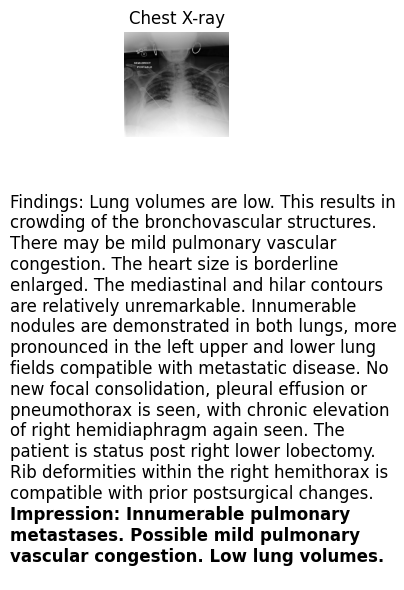

In [47]:
import matplotlib.pyplot as plt

# Assuming sample_data contains your data with the image
def display_sample(sample_data):
    # Extract components
    image = sample_data['image']
    findings = sample_data['findings']
    impression = sample_data['impression']
    
    # Create figure
    plt.figure(figsize=(4,6))
    
    # Display image
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Chest X-ray')
    
    # Display text
    plt.subplot(2, 1, 2)
    plt.axis('off')
    plt.text(0, 0.8, f"Findings: {findings}", wrap=True, fontsize=12)
    plt.text(0, 0.2, f"Impression: {impression}", wrap=True, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Call the function with your sample data
count = 0
for sample in train_dataset:
    count += 1
    if count > 3:
        break
    display_sample(sample)  # Replace with your actual variable name
# Replace with your actual variable name

In [48]:
# from PIL import Image
# import os

# file_path = sample['File_Path']  # this exists
# full_path = os.path.join(BASE_DIR, file_path)

# image = Image.open(full_path).convert("RGB")
# image.show()


In [49]:
# print(type(sample['image']))  # should be <class 'PIL.Image.Image'>
# sample['image'].show() 

In [50]:
# Preprocessing function
def preprocess(examples):
    images = [img.convert("RGB") for img in examples["image"]]
    texts = [text if text else "" for text in examples["impression"]]
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

# Custom PyTorch dataset wrapper
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example["image"].convert("RGB")
        text = example["impression"]
        return {"image": image, "text": text}
# from PIL import Image

# class CLIPDataset(torch.utils.data.Dataset):
#     def __init__(self, hf_dataset, root_dir=""):
#         self.dataset = hf_dataset
#         self.root_dir = root_dir  # Path to "MIMIC-CXR-JPG" folder

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         example = self.dataset[idx]
#         img_path = os.path.join(self.root_dir, example["File_Path"])
#         image = Image.open(img_path).convert("RGB")
#         text = example["Impression"]
#         return {"image": image, "text": text}


# # Collate function using CLIPProcessor
def collate_fn(batch):
    images = [b["image"] for b in batch]
    texts = [b["text"] for b in batch]
    return processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)



In [51]:
# DataLoader
train_ds = CLIPDataset(train_dataset)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Validation DataLoader
val_dataset = CLIPDataset(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
# Test DataLoader
test_dataset = CLIPDataset(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
# Training loop
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-6)

In [52]:
# from models.clip.dataset import ProcessedCLIPDa

In [53]:
# train_ds = ProcessedCLIPDataset("data/raw/texts/train.json", "data/raw")
# val_ds = ProcessedCLIPDataset("data/raw/texts/validation.json", "data/raw")
# test_ds = ProcessedCLIPDataset("data/raw/texts/test.json", "data/raw")

In [54]:
# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn,drop_last=True)


In [55]:
train_ds

In [56]:
train_loader

In [57]:
val_loader

In [58]:
val_dataset

## CLAUDE SUGGESTION:

In [59]:
# def do_train(model, train_loader, optimizer, epoch, device, scheduler=None, max_grad_norm=1.0):
#     model.train()
#     total_loss = 0.0
#     start_time = time.time()

#     for batch_idx, batch in enumerate(train_loader):
#         batch = {k: v.to(device) for k, v in batch.items()}

#         # Forward pass
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss

#         # Backward pass
#         loss.backward()

#         # Gradient clipping for stability
#         if max_grad_norm > 0:
#             clip_grad_norm_(model.parameters(), max_grad_norm)

#         optimizer.step()
#         optimizer.zero_grad()

#         total_loss += loss.item()

#         # Report progress for long epochs
#         if batch_idx % 50 == 0:
#             print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

#     # Step the scheduler if provided
#     if scheduler is not None:
#         scheduler.step()

#     train_time = time.time() - start_time
#     avg_train_loss = total_loss / len(train_loader)

#     return avg_train_loss, train_time

# @torch.no_grad()
# def do_eval(model, val_loader, device):
#     model.eval()
#     total_loss = 0.0
#     all_preds = []
#     all_labels = []
#     start_time = time.time()

#     for batch in val_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         # Get loss
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss
#         total_loss += loss.item()

#         # Get image and text features
#         image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
#         text_embeds = model.get_text_features(
#             input_ids=batch['input_ids'],
#             attention_mask=batch['attention_mask']
#         )

#         # Normalize
#         image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
#         text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

#         # Compute similarity
#         logits = torch.matmul(image_embeds, text_embeds.T) * model.logit_scale.exp()

#         # Prediction (diagonal elements should be highest)
#         preds = torch.argmax(logits, dim=1)
#         labels = torch.arange(len(preds)).to(device)

#         all_preds.extend(preds.cpu().tolist())
#         all_labels.extend(labels.cpu().tolist())

#     val_time = time.time() - start_time
#     avg_val_loss = total_loss / len(val_loader)
#     val_acc = accuracy_score(all_labels, all_preds)

#     return avg_val_loss, val_acc, val_time

In [60]:
def do_train(model, train_loader, optimizer, epoch, device, scheduler=None, max_grad_norm=1.0, log_interval=10):
    model.train()
    total_loss = 0.0
    start_time = time.time()
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} Training")
    
    for batch_idx, batch in enumerate(progress_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Get image and text features
        image_features = model.get_image_features(pixel_values=batch['pixel_values'])
        text_features = model.get_text_features(
            input_ids=batch['input_ids'],
            attention_mask=batch.get('attention_mask', None)  # Handle if attention_mask isn't available
        )
        
        # Normalize
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Compute logits
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.T
        logits_per_text = logits_per_image.T
        
        # Compute loss (bidirectional)
        batch_size = image_features.size(0)
        labels = torch.arange(batch_size, device=device)
        loss = (F.cross_entropy(logits_per_image, labels) + F.cross_entropy(logits_per_text, labels)) / 2
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        if max_grad_norm > 0:
            clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
        
        if batch_idx % log_interval == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch} [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}, LR: {lr:.6f}")
    
    # Step the scheduler if provided
    if scheduler is not None:
        scheduler.step()
    
    train_time = time.time() - start_time
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Avg Loss: {avg_train_loss:.4f}, Time: {train_time:.2f}s")
    
    return avg_train_loss, train_time
@torch.no_grad()
def do_eval(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    all_image_to_text_preds, all_image_to_text_labels = [], []
    all_text_to_image_preds, all_text_to_image_labels = [], []
    all_logits_per_image, all_logits_per_text = [], []
    start_time = time.time()
    
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Get loss
        outputs = model(**batch, return_loss=True)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Get image and text features
        image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
        text_embeds = model.get_text_features(
            input_ids=batch['input_ids'],
            attention_mask=batch.get('attention_mask', None)  # Handle if attention_mask isn't available
        )
        
        # Normalize
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        
        # Compute similarities in both directions
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * torch.matmul(image_embeds, text_embeds.T)
        logits_per_text = logits_per_image.T
        
        # Create labels (diagonal elements should match)
        batch_size = image_embeds.size(0)
        labels = torch.arange(batch_size).to(device)
        
        # Get predictions for both directions
        image_to_text_preds = torch.argmax(logits_per_image, dim=1)
        text_to_image_preds = torch.argmax(logits_per_text, dim=1)
        
        # Store results for later computation
        all_image_to_text_preds.extend(image_to_text_preds.cpu().tolist())
        all_image_to_text_labels.extend(labels.cpu().tolist())
        all_text_to_image_preds.extend(text_to_image_preds.cpu().tolist())
        all_text_to_image_labels.extend(labels.cpu().tolist())
        
        # Store logits for computing top-5 metrics
        all_logits_per_image.append(logits_per_image.cpu())
        all_logits_per_text.append(logits_per_text.cpu())
    
    # Compute metrics
    val_time = time.time() - start_time
    avg_val_loss = total_loss / len(val_loader)
    
    # Compute regular accuracy metrics
    image_to_text_acc = accuracy_score(all_image_to_text_labels, all_image_to_text_preds)
    text_to_image_acc = accuracy_score(all_text_to_image_labels, all_text_to_image_preds)
    
    # Compute top-5 metrics
    top5_image_scores, top5_text_scores = [], []
    for logits_img, logits_txt in zip(all_logits_per_image, all_logits_per_text):
        batch_size = logits_img.shape[0]
        labels = list(range(batch_size))
        k = min(5, batch_size)  # Handle batches smaller than 5
        
        # Use sklearn's top_k_accuracy_score
        top5_image_scores.append(top_k_accuracy_score(labels, logits_img.numpy(), k=k, labels=labels))
        top5_text_scores.append(top_k_accuracy_score(labels, logits_txt.numpy(), k=k, labels=labels))
    
    # Average top-5 scores across batches
    image_to_text_top5 = sum(top5_image_scores) / len(top5_image_scores) if top5_image_scores else 0
    text_to_image_top5 = sum(top5_text_scores) / len(top5_text_scores) if top5_text_scores else 0
    
    # Display results
    print(f"Validation Results:")
    print(f"  Loss: {avg_val_loss:.4f}")
    print(f"  Image→Text Accuracy: {image_to_text_acc:.4f} (Top-5: {image_to_text_top5:.4f})")
    print(f"  Text→Image Accuracy: {text_to_image_acc:.4f} (Top-5: {text_to_image_top5:.4f})")
    
    # Return all metrics
    return {
        "avg_val_loss": avg_val_loss,
        "image_to_text_acc": image_to_text_acc,
        "text_to_image_acc": text_to_image_acc,
        "image_to_text_top5": image_to_text_top5,
        "text_to_image_top5": text_to_image_top5,
        "val_time": val_time
    }

In [61]:
import torch.nn.functional as F


In [62]:
# train_losses, val_losses, val_accuracies = [], [], []

# EPOCHS=6
# for epoch in range(EPOCHS):
#     print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

#     avg_train_loss, train_time = do_train(model, train_loader, optimizer, epoch, device="cuda")
#     avg_val_loss,val_acc, val_time = do_eval(model, val_loader, device="cuda")
#     print(f"\n🚀Epoch {epoch+1} Summary:")
#     print(f"✅ Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {train_time:.2f}s")
#     print(f"📊 Validation Loss: {avg_val_loss:.4f} | val_Acc: {val_acc*100:.4f}% | Time: {val_time:.2f}s")

#     train_losses.append(avg_train_loss)
#     val_losses.append(avg_val_loss)
#     val_accuracies.append(val_acc)


In [63]:
import pandas as pd

# Initialize DataFrame to store metrics
metrics_df = pd.DataFrame(columns=[
    "epoch", "train_loss", "val_loss", "image_to_text_acc", "text_to_image_acc",
    "image_to_text_top5", "text_to_image_top5", "train_time", "val_time"
])

EPOCHS = 3
import torch

best_acc = 0.0  # Initialize best metric
best_model_path = "best_clip_model.pt"

for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

    avg_train_loss, train_time = do_train(model, train_loader, optimizer, epoch, device="cuda")
    eval_results = do_eval(model, val_loader, device="cuda")

    current_acc = eval_results["image_to_text_acc"]
    
    # Save best model
    if current_acc > best_acc:
        best_acc = current_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"💾 Saved new best model at epoch {epoch+1} with I→T Acc: {current_acc*100:.2f}%")

    # Append metrics
    metrics_df.loc[len(metrics_df)] = {
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": eval_results["avg_val_loss"],
        "image_to_text_acc": current_acc,
        "text_to_image_acc": eval_results["text_to_image_acc"],
        "image_to_text_top5": eval_results["image_to_text_top5"],
        "text_to_image_top5": eval_results["text_to_image_top5"],
        "train_time": train_time,
        "val_time": eval_results["val_time"]
    }



🚀 Epoch 1/3


Epoch 0 Training:   0%|          | 2/1532 [00:00<05:25,  4.70it/s, loss=3.73]

Epoch 0 [0/1532] Loss: 3.6468, LR: 0.000005


Epoch 0 Training:   1%|          | 12/1532 [00:02<04:33,  5.56it/s, loss=2.77]

Epoch 0 [10/1532] Loss: 2.7599, LR: 0.000005


Epoch 0 Training:   1%|          | 13/1532 [00:02<04:37,  5.48it/s, loss=2.89]

Epoch 0 Training:   1%|▏         | 22/1532 [00:04<04:35,  5.47it/s, loss=2.8] 

Epoch 0 [20/1532] Loss: 2.8061, LR: 0.000005


Epoch 0 Training:   2%|▏         | 32/1532 [00:05<04:39,  5.36it/s, loss=2.77]

Epoch 0 [30/1532] Loss: 2.7788, LR: 0.000005


Epoch 0 Training:   3%|▎         | 42/1532 [00:07<04:34,  5.43it/s, loss=2.73]

Epoch 0 [40/1532] Loss: 2.7507, LR: 0.000005


Epoch 0 Training:   3%|▎         | 52/1532 [00:09<04:28,  5.51it/s, loss=2.37]

Epoch 0 [50/1532] Loss: 2.6627, LR: 0.000005


Epoch 0 Training:   4%|▍         | 62/1532 [00:11<04:28,  5.48it/s, loss=2.87]

Epoch 0 [60/1532] Loss: 2.8501, LR: 0.000005


Epoch 0 Training:   5%|▍         | 72/1532 [00:13<04:22,  5.57it/s, loss=2.75]

Epoch 0 [70/1532] Loss: 2.7376, LR: 0.000005


Epoch 0 Training:   5%|▌         | 82/1532 [00:15<04:25,  5.47it/s, loss=2.67]

Epoch 0 [80/1532] Loss: 2.6138, LR: 0.000005


Epoch 0 Training:   6%|▌         | 92/1532 [00:16<04:16,  5.62it/s, loss=2.7] 

Epoch 0 [90/1532] Loss: 2.6266, LR: 0.000005


Epoch 0 Training:   7%|▋         | 102/1532 [00:18<04:17,  5.55it/s, loss=2.57]

Epoch 0 [100/1532] Loss: 2.6220, LR: 0.000005


Epoch 0 Training:   7%|▋         | 112/1532 [00:20<04:24,  5.38it/s, loss=2.62]

Epoch 0 [110/1532] Loss: 2.4720, LR: 0.000005


Epoch 0 Training:   8%|▊         | 122/1532 [00:22<04:25,  5.32it/s, loss=2.72]

Epoch 0 [120/1532] Loss: 2.7183, LR: 0.000005


Epoch 0 Training:   9%|▊         | 132/1532 [00:24<04:15,  5.49it/s, loss=2.6] 

Epoch 0 [130/1532] Loss: 2.6655, LR: 0.000005


Epoch 0 Training:   9%|▉         | 142/1532 [00:26<04:17,  5.39it/s, loss=2.46]

Epoch 0 [140/1532] Loss: 2.5548, LR: 0.000005


Epoch 0 Training:  10%|▉         | 152/1532 [00:27<04:14,  5.43it/s, loss=2.49]

Epoch 0 [150/1532] Loss: 2.5174, LR: 0.000005


Epoch 0 Training:  11%|█         | 162/1532 [00:29<04:05,  5.57it/s, loss=2.5] 

Epoch 0 [160/1532] Loss: 2.4841, LR: 0.000005


Epoch 0 Training:  11%|█         | 172/1532 [00:31<04:08,  5.46it/s, loss=2.26]

Epoch 0 [170/1532] Loss: 2.4845, LR: 0.000005


Epoch 0 Training:  12%|█▏        | 182/1532 [00:33<04:17,  5.25it/s, loss=2.54]

Epoch 0 [180/1532] Loss: 2.5469, LR: 0.000005


Epoch 0 Training:  13%|█▎        | 192/1532 [00:35<04:02,  5.52it/s, loss=2.3] 

Epoch 0 [190/1532] Loss: 2.6010, LR: 0.000005


Epoch 0 Training:  13%|█▎        | 202/1532 [00:37<04:10,  5.32it/s, loss=2.49]

Epoch 0 [200/1532] Loss: 2.3937, LR: 0.000005


Epoch 0 Training:  14%|█▍        | 212/1532 [00:38<04:11,  5.25it/s, loss=2.52]

Epoch 0 [210/1532] Loss: 2.4579, LR: 0.000005


Epoch 0 Training:  14%|█▍        | 222/1532 [00:40<03:57,  5.53it/s, loss=2.28]

Epoch 0 [220/1532] Loss: 2.6613, LR: 0.000005


Epoch 0 Training:  15%|█▌        | 232/1532 [00:42<03:57,  5.47it/s, loss=2.4] 

Epoch 0 [230/1532] Loss: 2.4905, LR: 0.000005


Epoch 0 Training:  16%|█▌        | 242/1532 [00:44<03:57,  5.44it/s, loss=2.45]

Epoch 0 [240/1532] Loss: 2.6370, LR: 0.000005


Epoch 0 Training:  16%|█▋        | 252/1532 [00:46<03:49,  5.59it/s, loss=2.41]

Epoch 0 [250/1532] Loss: 2.4036, LR: 0.000005


Epoch 0 Training:  17%|█▋        | 262/1532 [00:48<03:51,  5.47it/s, loss=2.57]

Epoch 0 [260/1532] Loss: 2.1214, LR: 0.000005


Epoch 0 Training:  18%|█▊        | 272/1532 [00:49<03:50,  5.47it/s, loss=2.5] 

Epoch 0 [270/1532] Loss: 2.3607, LR: 0.000005


Epoch 0 Training:  18%|█▊        | 282/1532 [00:51<03:51,  5.40it/s, loss=2.36]

Epoch 0 [280/1532] Loss: 2.2700, LR: 0.000005


Epoch 0 Training:  19%|█▉        | 292/1532 [00:53<03:53,  5.32it/s, loss=2.3] 

Epoch 0 [290/1532] Loss: 2.6067, LR: 0.000005


Epoch 0 Training:  20%|█▉        | 302/1532 [00:55<03:46,  5.42it/s, loss=2.15]

Epoch 0 [300/1532] Loss: 2.3067, LR: 0.000005


Epoch 0 Training:  20%|██        | 312/1532 [00:57<03:40,  5.53it/s, loss=2.7] 

Epoch 0 [310/1532] Loss: 3.0453, LR: 0.000005


Epoch 0 Training:  21%|██        | 322/1532 [00:59<03:44,  5.39it/s, loss=2.24]

Epoch 0 [320/1532] Loss: 2.2927, LR: 0.000005


Epoch 0 Training:  22%|██▏       | 332/1532 [01:01<03:40,  5.44it/s, loss=2.66]

Epoch 0 [330/1532] Loss: 2.5260, LR: 0.000005


Epoch 0 Training:  22%|██▏       | 342/1532 [01:02<03:42,  5.35it/s, loss=2.27]

Epoch 0 [340/1532] Loss: 2.4300, LR: 0.000005


Epoch 0 Training:  23%|██▎       | 352/1532 [01:04<03:41,  5.32it/s, loss=2.49]

Epoch 0 [350/1532] Loss: 2.1751, LR: 0.000005


Epoch 0 Training:  24%|██▎       | 362/1532 [01:06<03:31,  5.53it/s, loss=2.56]

Epoch 0 [360/1532] Loss: 2.2433, LR: 0.000005


Epoch 0 Training:  24%|██▍       | 371/1532 [01:08<03:41,  5.24it/s, loss=2.51]

Epoch 0 [370/1532] Loss: 2.5081, LR: 0.000005


Epoch 0 Training:  25%|██▍       | 382/1532 [01:10<03:36,  5.31it/s, loss=2.13]

Epoch 0 [380/1532] Loss: 2.4193, LR: 0.000005


Epoch 0 Training:  26%|██▌       | 392/1532 [01:12<03:38,  5.22it/s, loss=2.06]

Epoch 0 [390/1532] Loss: 2.0235, LR: 0.000005


Epoch 0 Training:  26%|██▌       | 402/1532 [01:14<03:31,  5.34it/s, loss=2.66]

Epoch 0 [400/1532] Loss: 2.5132, LR: 0.000005


Epoch 0 Training:  27%|██▋       | 412/1532 [01:16<03:35,  5.21it/s, loss=2.26]

Epoch 0 [410/1532] Loss: 2.1231, LR: 0.000005


Epoch 0 Training:  28%|██▊       | 422/1532 [01:18<03:28,  5.33it/s, loss=2.32]

Epoch 0 [420/1532] Loss: 2.3426, LR: 0.000005


Epoch 0 Training:  28%|██▊       | 432/1532 [01:19<03:36,  5.09it/s, loss=2.29]

Epoch 0 [430/1532] Loss: 2.3547, LR: 0.000005


Epoch 0 Training:  29%|██▉       | 442/1532 [01:21<03:32,  5.14it/s, loss=2.24]

Epoch 0 [440/1532] Loss: 2.1326, LR: 0.000005


Epoch 0 Training:  30%|██▉       | 452/1532 [01:23<03:28,  5.19it/s, loss=2.09]

Epoch 0 [450/1532] Loss: 2.3199, LR: 0.000005


Epoch 0 Training:  30%|███       | 462/1532 [01:25<03:24,  5.24it/s, loss=2.55]

Epoch 0 [460/1532] Loss: 2.1862, LR: 0.000005


Epoch 0 Training:  31%|███       | 472/1532 [01:27<03:16,  5.38it/s, loss=2.68]

Epoch 0 [470/1532] Loss: 2.0703, LR: 0.000005


Epoch 0 Training:  31%|███▏      | 482/1532 [01:29<03:21,  5.21it/s, loss=2.89]

Epoch 0 [480/1532] Loss: 2.3534, LR: 0.000005


Epoch 0 Training:  32%|███▏      | 492/1532 [01:31<03:08,  5.52it/s, loss=2.3] 

Epoch 0 [490/1532] Loss: 2.7476, LR: 0.000005


Epoch 0 Training:  33%|███▎      | 502/1532 [01:33<03:18,  5.19it/s, loss=2.61]

Epoch 0 [500/1532] Loss: 2.5656, LR: 0.000005


Epoch 0 Training:  33%|███▎      | 512/1532 [01:35<03:17,  5.16it/s, loss=2.23]

Epoch 0 [510/1532] Loss: 2.5232, LR: 0.000005


Epoch 0 Training:  34%|███▍      | 522/1532 [01:37<03:10,  5.29it/s, loss=2.26]

Epoch 0 [520/1532] Loss: 2.1572, LR: 0.000005


Epoch 0 Training:  35%|███▍      | 532/1532 [01:39<03:13,  5.17it/s, loss=2.3] 

Epoch 0 [530/1532] Loss: 2.2719, LR: 0.000005


Epoch 0 Training:  35%|███▌      | 542/1532 [01:40<03:11,  5.16it/s, loss=2.41]

Epoch 0 [540/1532] Loss: 2.1379, LR: 0.000005


Epoch 0 Training:  36%|███▌      | 552/1532 [01:42<03:05,  5.29it/s, loss=2.67]

Epoch 0 [550/1532] Loss: 1.7865, LR: 0.000005


Epoch 0 Training:  37%|███▋      | 562/1532 [01:44<03:00,  5.37it/s, loss=2.43]

Epoch 0 [560/1532] Loss: 2.3694, LR: 0.000005


Epoch 0 Training:  37%|███▋      | 571/1532 [01:46<03:04,  5.21it/s, loss=2.56]

Epoch 0 [570/1532] Loss: 2.3049, LR: 0.000005


Epoch 0 Training:  38%|███▊      | 582/1532 [01:48<03:05,  5.12it/s, loss=1.97]

Epoch 0 [580/1532] Loss: 2.2911, LR: 0.000005


Epoch 0 Training:  39%|███▊      | 591/1532 [01:50<03:04,  5.11it/s, loss=2.33]

Epoch 0 [590/1532] Loss: 2.4632, LR: 0.000005


Epoch 0 Training:  39%|███▉      | 602/1532 [01:52<02:57,  5.24it/s, loss=2.18]

Epoch 0 [600/1532] Loss: 2.0904, LR: 0.000005


Epoch 0 Training:  40%|███▉      | 611/1532 [01:54<02:56,  5.22it/s, loss=2.29]

Epoch 0 [610/1532] Loss: 2.5927, LR: 0.000005


Epoch 0 Training:  41%|████      | 622/1532 [01:56<02:54,  5.20it/s, loss=2.4] 

Epoch 0 [620/1532] Loss: 2.3001, LR: 0.000005


Epoch 0 Training:  41%|████▏     | 632/1532 [01:58<02:48,  5.33it/s, loss=2.75]

Epoch 0 [630/1532] Loss: 2.5466, LR: 0.000005


Epoch 0 Training:  42%|████▏     | 642/1532 [02:00<02:47,  5.31it/s, loss=2.1] 

Epoch 0 [640/1532] Loss: 2.3138, LR: 0.000005


Epoch 0 Training:  43%|████▎     | 652/1532 [02:02<02:49,  5.19it/s, loss=2]   

Epoch 0 [650/1532] Loss: 2.3602, LR: 0.000005


Epoch 0 Training:  43%|████▎     | 662/1532 [02:03<02:42,  5.36it/s, loss=2.17]

Epoch 0 [660/1532] Loss: 2.0519, LR: 0.000005


Epoch 0 Training:  44%|████▍     | 672/1532 [02:05<02:35,  5.52it/s, loss=2.34]

Epoch 0 [670/1532] Loss: 2.1974, LR: 0.000005


Epoch 0 Training:  45%|████▍     | 682/1532 [02:07<02:39,  5.34it/s, loss=2.24]

Epoch 0 [680/1532] Loss: 2.1461, LR: 0.000005


Epoch 0 Training:  45%|████▌     | 692/1532 [02:09<02:37,  5.33it/s, loss=2.07]

Epoch 0 [690/1532] Loss: 2.0671, LR: 0.000005


Epoch 0 Training:  46%|████▌     | 702/1532 [02:11<02:33,  5.41it/s, loss=2.17]

Epoch 0 [700/1532] Loss: 2.0870, LR: 0.000005


Epoch 0 Training:  46%|████▋     | 712/1532 [02:13<02:37,  5.20it/s, loss=2.01]

Epoch 0 [710/1532] Loss: 2.0335, LR: 0.000005


Epoch 0 Training:  47%|████▋     | 722/1532 [02:15<02:31,  5.36it/s, loss=2.59]

Epoch 0 [720/1532] Loss: 2.0072, LR: 0.000005


Epoch 0 Training:  48%|████▊     | 731/1532 [02:17<02:35,  5.15it/s, loss=2.42]

Epoch 0 [730/1532] Loss: 1.9605, LR: 0.000005


Epoch 0 Training:  48%|████▊     | 742/1532 [02:19<02:25,  5.44it/s, loss=2]   

Epoch 0 [740/1532] Loss: 2.0885, LR: 0.000005


Epoch 0 Training:  49%|████▉     | 752/1532 [02:20<02:26,  5.31it/s, loss=3.23]

Epoch 0 [750/1532] Loss: 2.3038, LR: 0.000005


Epoch 0 Training:  50%|████▉     | 762/1532 [02:22<02:23,  5.36it/s, loss=2.03]

Epoch 0 [760/1532] Loss: 2.1114, LR: 0.000005


Epoch 0 Training:  50%|█████     | 772/1532 [02:24<02:19,  5.46it/s, loss=1.65]

Epoch 0 [770/1532] Loss: 1.9766, LR: 0.000005


Epoch 0 Training:  51%|█████     | 782/1532 [02:26<02:25,  5.16it/s, loss=2.03]

Epoch 0 [780/1532] Loss: 1.7900, LR: 0.000005


Epoch 0 Training:  52%|█████▏    | 792/1532 [02:28<02:24,  5.12it/s, loss=2.42]

Epoch 0 [790/1532] Loss: 2.1357, LR: 0.000005


Epoch 0 Training:  52%|█████▏    | 802/1532 [02:30<02:20,  5.19it/s, loss=2.31]

Epoch 0 [800/1532] Loss: 1.9178, LR: 0.000005


Epoch 0 Training:  53%|█████▎    | 812/1532 [02:32<02:15,  5.32it/s, loss=2.03]

Epoch 0 [810/1532] Loss: 2.3785, LR: 0.000005


Epoch 0 Training:  54%|█████▎    | 822/1532 [02:34<02:14,  5.26it/s, loss=1.78]

Epoch 0 [820/1532] Loss: 2.4389, LR: 0.000005


Epoch 0 Training:  54%|█████▍    | 832/1532 [02:36<02:15,  5.17it/s, loss=1.76]

Epoch 0 [830/1532] Loss: 1.9098, LR: 0.000005


Epoch 0 Training:  55%|█████▍    | 842/1532 [02:38<02:16,  5.05it/s, loss=2.33]

Epoch 0 [840/1532] Loss: 2.3812, LR: 0.000005


Epoch 0 Training:  56%|█████▌    | 852/1532 [02:39<02:10,  5.20it/s, loss=2.43]

Epoch 0 [850/1532] Loss: 2.3541, LR: 0.000005


Epoch 0 Training:  56%|█████▌    | 861/1532 [02:41<02:09,  5.20it/s, loss=2.25]

Epoch 0 [860/1532] Loss: 2.3092, LR: 0.000005


Epoch 0 Training:  57%|█████▋    | 872/1532 [02:43<02:05,  5.25it/s, loss=2.18]

Epoch 0 [870/1532] Loss: 2.3877, LR: 0.000005


Epoch 0 Training:  58%|█████▊    | 882/1532 [02:45<02:03,  5.28it/s, loss=2.55]

Epoch 0 [880/1532] Loss: 1.9888, LR: 0.000005


Epoch 0 Training:  58%|█████▊    | 892/1532 [02:47<02:05,  5.10it/s, loss=2.13]

Epoch 0 [890/1532] Loss: 1.8958, LR: 0.000005


Epoch 0 Training:  59%|█████▉    | 902/1532 [02:49<02:02,  5.12it/s, loss=2.22]

Epoch 0 [900/1532] Loss: 2.0121, LR: 0.000005


Epoch 0 Training:  60%|█████▉    | 912/1532 [02:51<01:59,  5.17it/s, loss=2.09]

Epoch 0 [910/1532] Loss: 2.0248, LR: 0.000005


Epoch 0 Training:  60%|██████    | 922/1532 [02:53<01:57,  5.20it/s, loss=2.16]

Epoch 0 [920/1532] Loss: 1.9665, LR: 0.000005


Epoch 0 Training:  61%|██████    | 932/1532 [02:55<01:54,  5.24it/s, loss=1.98]

Epoch 0 [930/1532] Loss: 1.8540, LR: 0.000005


Epoch 0 Training:  61%|██████▏   | 942/1532 [02:57<01:54,  5.15it/s, loss=2.05]

Epoch 0 [940/1532] Loss: 2.0364, LR: 0.000005


Epoch 0 Training:  62%|██████▏   | 952/1532 [02:59<01:52,  5.16it/s, loss=2.03]

Epoch 0 [950/1532] Loss: 2.4714, LR: 0.000005


Epoch 0 Training:  63%|██████▎   | 962/1532 [03:01<01:47,  5.30it/s, loss=1.8] 

Epoch 0 [960/1532] Loss: 2.6248, LR: 0.000005


Epoch 0 Training:  63%|██████▎   | 972/1532 [03:02<01:48,  5.17it/s, loss=2.12]

Epoch 0 [970/1532] Loss: 1.9937, LR: 0.000005


Epoch 0 Training:  64%|██████▍   | 982/1532 [03:04<01:43,  5.34it/s, loss=2.44]

Epoch 0 [980/1532] Loss: 2.4940, LR: 0.000005


Epoch 0 Training:  65%|██████▍   | 992/1532 [03:06<01:42,  5.27it/s, loss=2.03]

Epoch 0 [990/1532] Loss: 1.7296, LR: 0.000005


Epoch 0 Training:  65%|██████▌   | 1001/1532 [03:08<01:43,  5.14it/s, loss=2.06]

Epoch 0 [1000/1532] Loss: 2.4014, LR: 0.000005


Epoch 0 Training:  66%|██████▌   | 1012/1532 [03:10<01:37,  5.34it/s, loss=2.21]

Epoch 0 [1010/1532] Loss: 2.2157, LR: 0.000005


Epoch 0 Training:  67%|██████▋   | 1022/1532 [03:12<01:38,  5.15it/s, loss=2.13]

Epoch 0 [1020/1532] Loss: 2.3376, LR: 0.000005


Epoch 0 Training:  67%|██████▋   | 1032/1532 [03:14<01:31,  5.44it/s, loss=2.27]

Epoch 0 [1030/1532] Loss: 2.3717, LR: 0.000005


Epoch 0 Training:  68%|██████▊   | 1042/1532 [03:16<01:31,  5.38it/s, loss=2.36]

Epoch 0 [1040/1532] Loss: 2.2764, LR: 0.000005


Epoch 0 Training:  69%|██████▊   | 1052/1532 [03:18<01:28,  5.43it/s, loss=2.41]

Epoch 0 [1050/1532] Loss: 2.1791, LR: 0.000005


Epoch 0 Training:  69%|██████▉   | 1062/1532 [03:19<01:29,  5.26it/s, loss=1.7] 

Epoch 0 [1060/1532] Loss: 2.1165, LR: 0.000005


Epoch 0 Training:  70%|██████▉   | 1072/1532 [03:21<01:27,  5.27it/s, loss=2.16]

Epoch 0 [1070/1532] Loss: 2.3497, LR: 0.000005


Epoch 0 Training:  71%|███████   | 1082/1532 [03:23<01:25,  5.28it/s, loss=1.67]

Epoch 0 [1080/1532] Loss: 1.8250, LR: 0.000005


Epoch 0 Training:  71%|███████▏  | 1092/1532 [03:25<01:25,  5.13it/s, loss=2.22]

Epoch 0 [1090/1532] Loss: 1.5655, LR: 0.000005


Epoch 0 Training:  72%|███████▏  | 1102/1532 [03:27<01:21,  5.30it/s, loss=2.17]

Epoch 0 [1100/1532] Loss: 1.6758, LR: 0.000005


Epoch 0 Training:  73%|███████▎  | 1111/1532 [03:29<01:17,  5.42it/s, loss=1.79]

Epoch 0 [1110/1532] Loss: 2.0017, LR: 0.000005


Epoch 0 Training:  73%|███████▎  | 1122/1532 [03:31<01:20,  5.09it/s, loss=2.1] 

Epoch 0 [1120/1532] Loss: 1.6402, LR: 0.000005


Epoch 0 Training:  74%|███████▍  | 1132/1532 [03:33<01:15,  5.28it/s, loss=2.27]

Epoch 0 [1130/1532] Loss: 1.8603, LR: 0.000005


Epoch 0 Training:  75%|███████▍  | 1142/1532 [03:35<01:14,  5.26it/s, loss=2.03]

Epoch 0 [1140/1532] Loss: 2.0900, LR: 0.000005


Epoch 0 Training:  75%|███████▌  | 1152/1532 [03:37<01:13,  5.20it/s, loss=1.85]

Epoch 0 [1150/1532] Loss: 1.8343, LR: 0.000005


Epoch 0 Training:  76%|███████▌  | 1162/1532 [03:39<01:11,  5.19it/s, loss=1.85]

Epoch 0 [1160/1532] Loss: 1.9618, LR: 0.000005


Epoch 0 Training:  76%|███████▋  | 1171/1532 [03:40<01:11,  5.06it/s, loss=2.02]

Epoch 0 [1170/1532] Loss: 2.0243, LR: 0.000005


Epoch 0 Training:  77%|███████▋  | 1182/1532 [03:43<01:08,  5.10it/s, loss=1.84]

Epoch 0 [1180/1532] Loss: 1.6737, LR: 0.000005


Epoch 0 Training:  78%|███████▊  | 1192/1532 [03:44<01:04,  5.26it/s, loss=2.05]

Epoch 0 [1190/1532] Loss: 1.9162, LR: 0.000005


Epoch 0 Training:  78%|███████▊  | 1202/1532 [03:46<01:08,  4.79it/s, loss=2.18]

Epoch 0 [1200/1532] Loss: 2.2063, LR: 0.000005


Epoch 0 Training:  79%|███████▉  | 1212/1532 [03:48<00:59,  5.38it/s, loss=2.16]

Epoch 0 [1210/1532] Loss: 1.6220, LR: 0.000005


Epoch 0 Training:  80%|███████▉  | 1222/1532 [03:50<00:58,  5.30it/s, loss=1.45]

Epoch 0 [1220/1532] Loss: 1.7316, LR: 0.000005


Epoch 0 Training:  80%|████████  | 1232/1532 [03:52<00:55,  5.36it/s, loss=2.08]

Epoch 0 [1230/1532] Loss: 1.7382, LR: 0.000005


Epoch 0 Training:  81%|████████  | 1242/1532 [03:54<00:56,  5.15it/s, loss=1.73]

Epoch 0 [1240/1532] Loss: 1.7731, LR: 0.000005


Epoch 0 Training:  82%|████████▏ | 1252/1532 [03:56<00:52,  5.36it/s, loss=2.21]

Epoch 0 [1250/1532] Loss: 2.2823, LR: 0.000005


Epoch 0 Training:  82%|████████▏ | 1262/1532 [03:58<00:52,  5.17it/s, loss=1.77]

Epoch 0 [1260/1532] Loss: 2.0968, LR: 0.000005


Epoch 0 Training:  83%|████████▎ | 1272/1532 [04:00<00:48,  5.34it/s, loss=2.16]

Epoch 0 [1270/1532] Loss: 1.8402, LR: 0.000005


Epoch 0 Training:  84%|████████▎ | 1282/1532 [04:02<00:48,  5.18it/s, loss=2.09]

Epoch 0 [1280/1532] Loss: 1.8213, LR: 0.000005


Epoch 0 Training:  84%|████████▍ | 1292/1532 [04:04<00:44,  5.37it/s, loss=1.97]

Epoch 0 [1290/1532] Loss: 1.8843, LR: 0.000005


Epoch 0 Training:  85%|████████▍ | 1302/1532 [04:05<00:43,  5.25it/s, loss=1.54]

Epoch 0 [1300/1532] Loss: 2.1366, LR: 0.000005


Epoch 0 Training:  86%|████████▌ | 1312/1532 [04:07<00:42,  5.21it/s, loss=1.68]

Epoch 0 [1310/1532] Loss: 1.8053, LR: 0.000005


Epoch 0 Training:  86%|████████▋ | 1322/1532 [04:09<00:39,  5.32it/s, loss=2.45]

Epoch 0 [1320/1532] Loss: 2.2106, LR: 0.000005


Epoch 0 Training:  87%|████████▋ | 1332/1532 [04:11<00:37,  5.35it/s, loss=1.82]

Epoch 0 [1330/1532] Loss: 2.2594, LR: 0.000005


Epoch 0 Training:  88%|████████▊ | 1342/1532 [04:13<00:35,  5.37it/s, loss=2.12]

Epoch 0 [1340/1532] Loss: 1.9390, LR: 0.000005


Epoch 0 Training:  88%|████████▊ | 1352/1532 [04:15<00:34,  5.28it/s, loss=1.92]

Epoch 0 [1350/1532] Loss: 2.0330, LR: 0.000005


Epoch 0 Training:  89%|████████▉ | 1362/1532 [04:17<00:32,  5.26it/s, loss=2.15]

Epoch 0 [1360/1532] Loss: 2.0488, LR: 0.000005


Epoch 0 Training:  90%|████████▉ | 1372/1532 [04:19<00:30,  5.26it/s, loss=2.2] 

Epoch 0 [1370/1532] Loss: 1.9029, LR: 0.000005


Epoch 0 Training:  90%|█████████ | 1382/1532 [04:21<00:28,  5.20it/s, loss=1.82]

Epoch 0 [1380/1532] Loss: 2.4969, LR: 0.000005


Epoch 0 Training:  91%|█████████ | 1392/1532 [04:22<00:26,  5.28it/s, loss=2.43]

Epoch 0 [1390/1532] Loss: 2.2629, LR: 0.000005


Epoch 0 Training:  92%|█████████▏| 1402/1532 [04:24<00:24,  5.24it/s, loss=1.68]

Epoch 0 [1400/1532] Loss: 1.6044, LR: 0.000005


Epoch 0 Training:  92%|█████████▏| 1412/1532 [04:26<00:23,  5.09it/s, loss=1.64]

Epoch 0 [1410/1532] Loss: 1.9698, LR: 0.000005


Epoch 0 Training:  93%|█████████▎| 1422/1532 [04:28<00:21,  5.17it/s, loss=1.94]

Epoch 0 [1420/1532] Loss: 1.9571, LR: 0.000005


Epoch 0 Training:  93%|█████████▎| 1432/1532 [04:30<00:19,  5.26it/s, loss=2.35]

Epoch 0 [1430/1532] Loss: 2.3199, LR: 0.000005


Epoch 0 Training:  94%|█████████▍| 1442/1532 [04:32<00:16,  5.30it/s, loss=1.81]

Epoch 0 [1440/1532] Loss: 1.9806, LR: 0.000005


Epoch 0 Training:  95%|█████████▍| 1452/1532 [04:34<00:15,  5.20it/s, loss=2.27]

Epoch 0 [1450/1532] Loss: 1.9846, LR: 0.000005


Epoch 0 Training:  95%|█████████▌| 1462/1532 [04:36<00:13,  5.25it/s, loss=2.48]

Epoch 0 [1460/1532] Loss: 1.4590, LR: 0.000005


Epoch 0 Training:  96%|█████████▌| 1472/1532 [04:38<00:11,  5.35it/s, loss=2.15]

Epoch 0 [1470/1532] Loss: 1.9382, LR: 0.000005


Epoch 0 Training:  97%|█████████▋| 1482/1532 [04:39<00:09,  5.44it/s, loss=1.86]

Epoch 0 [1480/1532] Loss: 1.7948, LR: 0.000005


Epoch 0 Training:  97%|█████████▋| 1492/1532 [04:41<00:07,  5.17it/s, loss=2.08]

Epoch 0 [1490/1532] Loss: 1.9302, LR: 0.000005


Epoch 0 Training:  98%|█████████▊| 1502/1532 [04:43<00:05,  5.17it/s, loss=1.67]

Epoch 0 [1500/1532] Loss: 1.7536, LR: 0.000005


Epoch 0 Training:  99%|█████████▊| 1512/1532 [04:45<00:03,  5.29it/s, loss=2.57]

Epoch 0 [1510/1532] Loss: 1.8867, LR: 0.000005


Epoch 0 Training:  99%|█████████▉| 1522/1532 [04:47<00:01,  5.40it/s, loss=2.01]

Epoch 0 [1520/1532] Loss: 1.9655, LR: 0.000005


Epoch 0 Training: 100%|██████████| 1532/1532 [04:49<00:00,  5.29it/s, loss=0.244]


Epoch 0 [1530/1532] Loss: 1.8859, LR: 0.000005
Epoch 0: Avg Loss: 2.2484, Time: 289.35s
Validation Results:
  Loss: 2.0715
  Image→Text Accuracy: 0.3116 (Top-5: 0.7666)
  Text→Image Accuracy: 0.2995 (Top-5: 0.7612)
💾 Saved new best model at epoch 1 with I→T Acc: 31.16%

🚀 Epoch 2/3


Epoch 1 Training:   0%|          | 1/1532 [00:00<04:44,  5.38it/s, loss=2.3]

Epoch 1 [0/1532] Loss: 2.3019, LR: 0.000005


Epoch 1 Training:   1%|          | 12/1532 [00:02<04:43,  5.36it/s, loss=2.17]

Epoch 1 [10/1532] Loss: 1.5596, LR: 0.000005


Epoch 1 Training:   1%|▏         | 22/1532 [00:04<04:44,  5.30it/s, loss=1.45]

Epoch 1 [20/1532] Loss: 1.7051, LR: 0.000005


Epoch 1 Training:   2%|▏         | 32/1532 [00:06<04:40,  5.34it/s, loss=1.76]

Epoch 1 [30/1532] Loss: 1.5475, LR: 0.000005


Epoch 1 Training:   3%|▎         | 42/1532 [00:07<04:38,  5.35it/s, loss=1.9] 

Epoch 1 [40/1532] Loss: 1.7287, LR: 0.000005


Epoch 1 Training:   3%|▎         | 52/1532 [00:09<04:47,  5.14it/s, loss=1.58]

Epoch 1 [50/1532] Loss: 1.3174, LR: 0.000005


Epoch 1 Training:   4%|▍         | 62/1532 [00:11<04:36,  5.31it/s, loss=1.7] 

Epoch 1 [60/1532] Loss: 1.8623, LR: 0.000005


Epoch 1 Training:   5%|▍         | 72/1532 [00:13<04:44,  5.13it/s, loss=1.93]

Epoch 1 [70/1532] Loss: 1.6754, LR: 0.000005


Epoch 1 Training:   5%|▌         | 82/1532 [00:15<04:40,  5.18it/s, loss=1.44]

Epoch 1 [80/1532] Loss: 1.6363, LR: 0.000005


Epoch 1 Training:   6%|▌         | 92/1532 [00:17<04:38,  5.16it/s, loss=1.46]

Epoch 1 [90/1532] Loss: 1.6527, LR: 0.000005


Epoch 1 Training:   7%|▋         | 102/1532 [00:19<04:30,  5.29it/s, loss=1.81]

Epoch 1 [100/1532] Loss: 2.0975, LR: 0.000005


Epoch 1 Training:   7%|▋         | 112/1532 [00:21<04:17,  5.50it/s, loss=1.98]

Epoch 1 [110/1532] Loss: 1.5452, LR: 0.000005


Epoch 1 Training:   8%|▊         | 122/1532 [00:23<04:30,  5.21it/s, loss=1.92]

Epoch 1 [120/1532] Loss: 1.7960, LR: 0.000005


Epoch 1 Training:   9%|▊         | 132/1532 [00:25<04:32,  5.13it/s, loss=1.65]

Epoch 1 [130/1532] Loss: 1.5205, LR: 0.000005


Epoch 1 Training:   9%|▉         | 142/1532 [00:26<04:28,  5.18it/s, loss=2.01]

Epoch 1 [140/1532] Loss: 1.5786, LR: 0.000005


Epoch 1 Training:  10%|▉         | 151/1532 [00:28<04:19,  5.31it/s, loss=1.91]

Epoch 1 [150/1532] Loss: 1.7559, LR: 0.000005


Epoch 1 Training:  11%|█         | 162/1532 [00:30<04:17,  5.32it/s, loss=1.45]

Epoch 1 [160/1532] Loss: 1.5189, LR: 0.000005


Epoch 1 Training:  11%|█         | 172/1532 [00:32<04:17,  5.28it/s, loss=2.12]

Epoch 1 [170/1532] Loss: 1.4384, LR: 0.000005


Epoch 1 Training:  12%|█▏        | 182/1532 [00:34<04:10,  5.40it/s, loss=2.38]

Epoch 1 [180/1532] Loss: 1.5324, LR: 0.000005


Epoch 1 Training:  13%|█▎        | 192/1532 [00:36<04:08,  5.39it/s, loss=1.37]

Epoch 1 [190/1532] Loss: 1.4933, LR: 0.000005


Epoch 1 Training:  13%|█▎        | 202/1532 [00:38<04:08,  5.35it/s, loss=1.65]

Epoch 1 [200/1532] Loss: 1.4989, LR: 0.000005


Epoch 1 Training:  14%|█▍        | 211/1532 [00:39<04:06,  5.36it/s, loss=1.56]

Epoch 1 [210/1532] Loss: 1.5648, LR: 0.000005


Epoch 1 Training:  14%|█▍        | 222/1532 [00:42<04:13,  5.17it/s, loss=1.59]

Epoch 1 [220/1532] Loss: 1.1863, LR: 0.000005


Epoch 1 Training:  15%|█▌        | 232/1532 [00:43<04:10,  5.19it/s, loss=1.72]

Epoch 1 [230/1532] Loss: 1.5656, LR: 0.000005


Epoch 1 Training:  16%|█▌        | 241/1532 [00:45<04:05,  5.26it/s, loss=1.79]

Epoch 1 [240/1532] Loss: 1.3463, LR: 0.000005


Epoch 1 Training:  16%|█▋        | 252/1532 [00:47<04:01,  5.30it/s, loss=1.21]

Epoch 1 [250/1532] Loss: 2.0121, LR: 0.000005


Epoch 1 Training:  17%|█▋        | 262/1532 [00:49<04:02,  5.24it/s, loss=1.85]

Epoch 1 [260/1532] Loss: 1.7123, LR: 0.000005


Epoch 1 Training:  18%|█▊        | 272/1532 [00:51<03:54,  5.37it/s, loss=1.5] 

Epoch 1 [270/1532] Loss: 2.2359, LR: 0.000005


Epoch 1 Training:  18%|█▊        | 282/1532 [00:53<03:53,  5.35it/s, loss=1.86]

Epoch 1 [280/1532] Loss: 1.1824, LR: 0.000005


Epoch 1 Training:  19%|█▉        | 292/1532 [00:55<03:54,  5.29it/s, loss=1.61]

Epoch 1 [290/1532] Loss: 1.9319, LR: 0.000005


Epoch 1 Training:  20%|█▉        | 302/1532 [00:57<03:54,  5.24it/s, loss=1.74]

Epoch 1 [300/1532] Loss: 1.5653, LR: 0.000005


Epoch 1 Training:  20%|██        | 312/1532 [00:59<03:49,  5.32it/s, loss=1.62]

Epoch 1 [310/1532] Loss: 1.6228, LR: 0.000005


Epoch 1 Training:  21%|██        | 322/1532 [01:01<03:48,  5.30it/s, loss=1.72]

Epoch 1 [320/1532] Loss: 1.5484, LR: 0.000005


Epoch 1 Training:  22%|██▏       | 332/1532 [01:02<03:43,  5.36it/s, loss=1.43]

Epoch 1 [330/1532] Loss: 1.6141, LR: 0.000005


Epoch 1 Training:  22%|██▏       | 342/1532 [01:04<03:42,  5.35it/s, loss=1.61]

Epoch 1 [340/1532] Loss: 1.8283, LR: 0.000005


Epoch 1 Training:  23%|██▎       | 352/1532 [01:06<03:43,  5.27it/s, loss=1.72]

Epoch 1 [350/1532] Loss: 1.9896, LR: 0.000005


Epoch 1 Training:  24%|██▎       | 362/1532 [01:08<03:44,  5.21it/s, loss=1.34]

Epoch 1 [360/1532] Loss: 1.4314, LR: 0.000005


Epoch 1 Training:  24%|██▍       | 372/1532 [01:10<03:39,  5.28it/s, loss=1.95]

Epoch 1 [370/1532] Loss: 2.1518, LR: 0.000005


Epoch 1 Training:  25%|██▍       | 382/1532 [01:12<03:38,  5.25it/s, loss=2.26]

Epoch 1 [380/1532] Loss: 1.4696, LR: 0.000005


Epoch 1 Training:  26%|██▌       | 392/1532 [01:14<03:34,  5.32it/s, loss=1.83]

Epoch 1 [390/1532] Loss: 1.4412, LR: 0.000005


Epoch 1 Training:  26%|██▌       | 402/1532 [01:16<03:41,  5.11it/s, loss=1.79]

Epoch 1 [400/1532] Loss: 1.2051, LR: 0.000005


Epoch 1 Training:  27%|██▋       | 412/1532 [01:18<03:38,  5.14it/s, loss=1.73]

Epoch 1 [410/1532] Loss: 1.3818, LR: 0.000005


Epoch 1 Training:  28%|██▊       | 422/1532 [01:20<03:34,  5.17it/s, loss=1.57]

Epoch 1 [420/1532] Loss: 1.8214, LR: 0.000005


Epoch 1 Training:  28%|██▊       | 432/1532 [01:22<03:34,  5.13it/s, loss=1.53]

Epoch 1 [430/1532] Loss: 1.5328, LR: 0.000005


Epoch 1 Training:  29%|██▉       | 442/1532 [01:23<03:29,  5.20it/s, loss=1.47]

Epoch 1 [440/1532] Loss: 1.7609, LR: 0.000005


Epoch 1 Training:  30%|██▉       | 452/1532 [01:25<03:22,  5.34it/s, loss=1.93] 

Epoch 1 [450/1532] Loss: 1.7687, LR: 0.000005


Epoch 1 Training:  30%|███       | 462/1532 [01:27<03:18,  5.39it/s, loss=2.44]

Epoch 1 [460/1532] Loss: 1.6338, LR: 0.000005


Epoch 1 Training:  31%|███       | 472/1532 [01:29<03:21,  5.27it/s, loss=1.94]

Epoch 1 [470/1532] Loss: 1.8751, LR: 0.000005


Epoch 1 Training:  31%|███▏      | 482/1532 [01:31<03:22,  5.19it/s, loss=1.51]

Epoch 1 [480/1532] Loss: 1.9204, LR: 0.000005


Epoch 1 Training:  32%|███▏      | 492/1532 [01:33<03:19,  5.22it/s, loss=1.88]

Epoch 1 [490/1532] Loss: 1.1789, LR: 0.000005


Epoch 1 Training:  33%|███▎      | 502/1532 [01:35<03:15,  5.28it/s, loss=1.33]

Epoch 1 [500/1532] Loss: 1.7657, LR: 0.000005


Epoch 1 Training:  33%|███▎      | 511/1532 [01:37<03:12,  5.30it/s, loss=1.9] 

Epoch 1 [510/1532] Loss: 1.3560, LR: 0.000005


Epoch 1 Training:  34%|███▍      | 522/1532 [01:39<03:10,  5.30it/s, loss=1.8] 

Epoch 1 [520/1532] Loss: 2.0711, LR: 0.000005


Epoch 1 Training:  35%|███▍      | 532/1532 [01:41<03:09,  5.26it/s, loss=1.46]

Epoch 1 [530/1532] Loss: 1.5924, LR: 0.000005


Epoch 1 Training:  35%|███▌      | 542/1532 [01:43<03:05,  5.33it/s, loss=1.86]

Epoch 1 [540/1532] Loss: 1.6038, LR: 0.000005


Epoch 1 Training:  36%|███▌      | 552/1532 [01:44<03:06,  5.26it/s, loss=1.56]

Epoch 1 [550/1532] Loss: 1.6595, LR: 0.000005


Epoch 1 Training:  37%|███▋      | 562/1532 [01:46<03:07,  5.18it/s, loss=1.73]

Epoch 1 [560/1532] Loss: 2.0247, LR: 0.000005


Epoch 1 Training:  37%|███▋      | 572/1532 [01:48<02:56,  5.44it/s, loss=2.27]

Epoch 1 [570/1532] Loss: 1.7062, LR: 0.000005


Epoch 1 Training:  38%|███▊      | 582/1532 [01:50<03:02,  5.20it/s, loss=1.65]

Epoch 1 [580/1532] Loss: 1.2989, LR: 0.000005


Epoch 1 Training:  39%|███▊      | 592/1532 [01:52<02:58,  5.27it/s, loss=1.19]

Epoch 1 [590/1532] Loss: 2.0431, LR: 0.000005


Epoch 1 Training:  39%|███▉      | 602/1532 [01:54<02:56,  5.26it/s, loss=1.27]

Epoch 1 [600/1532] Loss: 2.1536, LR: 0.000005


Epoch 1 Training:  40%|███▉      | 612/1532 [01:56<02:58,  5.16it/s, loss=1.91]

Epoch 1 [610/1532] Loss: 1.7422, LR: 0.000005


Epoch 1 Training:  41%|████      | 621/1532 [01:57<02:55,  5.19it/s, loss=1.54]

Epoch 1 [620/1532] Loss: 1.5373, LR: 0.000005


Epoch 1 Training:  41%|████▏     | 632/1532 [02:00<02:51,  5.25it/s, loss=1.4] 

Epoch 1 [630/1532] Loss: 1.5443, LR: 0.000005


Epoch 1 Training:  42%|████▏     | 642/1532 [02:02<02:53,  5.14it/s, loss=1.6] 

Epoch 1 [640/1532] Loss: 1.4630, LR: 0.000005


Epoch 1 Training:  43%|████▎     | 652/1532 [02:03<02:48,  5.22it/s, loss=1.35]

Epoch 1 [650/1532] Loss: 1.5284, LR: 0.000005


Epoch 1 Training:  43%|████▎     | 662/1532 [02:05<02:41,  5.39it/s, loss=1.46]

Epoch 1 [660/1532] Loss: 1.7078, LR: 0.000005


Epoch 1 Training:  44%|████▍     | 672/1532 [02:07<02:40,  5.37it/s, loss=1.92]

Epoch 1 [670/1532] Loss: 1.7049, LR: 0.000005


Epoch 1 Training:  45%|████▍     | 682/1532 [02:09<02:38,  5.36it/s, loss=2.13]

Epoch 1 [680/1532] Loss: 2.1589, LR: 0.000005


Epoch 1 Training:  45%|████▌     | 692/1532 [02:11<02:41,  5.20it/s, loss=1.51]

Epoch 1 [690/1532] Loss: 1.4920, LR: 0.000005


Epoch 1 Training:  46%|████▌     | 702/1532 [02:13<02:40,  5.17it/s, loss=1.47]

Epoch 1 [700/1532] Loss: 1.6800, LR: 0.000005


Epoch 1 Training:  46%|████▋     | 712/1532 [02:15<02:37,  5.21it/s, loss=1.66]

Epoch 1 [710/1532] Loss: 1.7010, LR: 0.000005


Epoch 1 Training:  47%|████▋     | 722/1532 [02:17<02:31,  5.35it/s, loss=1.44]

Epoch 1 [720/1532] Loss: 1.4739, LR: 0.000005


Epoch 1 Training:  48%|████▊     | 732/1532 [02:19<02:27,  5.42it/s, loss=1.76]

Epoch 1 [730/1532] Loss: 1.4376, LR: 0.000005


Epoch 1 Training:  48%|████▊     | 742/1532 [02:21<02:30,  5.24it/s, loss=2.28]

Epoch 1 [740/1532] Loss: 1.7176, LR: 0.000005


Epoch 1 Training:  49%|████▉     | 752/1532 [02:22<02:30,  5.20it/s, loss=1.45]

Epoch 1 [750/1532] Loss: 1.3137, LR: 0.000005


Epoch 1 Training:  50%|████▉     | 762/1532 [02:24<02:25,  5.29it/s, loss=1.8] 

Epoch 1 [760/1532] Loss: 2.3129, LR: 0.000005


Epoch 1 Training:  50%|█████     | 772/1532 [02:26<02:25,  5.22it/s, loss=1.35]

Epoch 1 [770/1532] Loss: 1.6536, LR: 0.000005


Epoch 1 Training:  51%|█████     | 782/1532 [02:28<02:25,  5.16it/s, loss=1.85]

Epoch 1 [780/1532] Loss: 1.4221, LR: 0.000005


Epoch 1 Training:  52%|█████▏    | 792/1532 [02:30<02:21,  5.23it/s, loss=1.62]

Epoch 1 [790/1532] Loss: 1.8014, LR: 0.000005


Epoch 1 Training:  52%|█████▏    | 802/1532 [02:32<02:20,  5.20it/s, loss=1.6] 

Epoch 1 [800/1532] Loss: 1.6760, LR: 0.000005


Epoch 1 Training:  53%|█████▎    | 812/1532 [02:34<02:18,  5.19it/s, loss=1.58]

Epoch 1 [810/1532] Loss: 1.7586, LR: 0.000005


Epoch 1 Training:  54%|█████▎    | 822/1532 [02:36<02:08,  5.52it/s, loss=1.76]

Epoch 1 [820/1532] Loss: 2.1842, LR: 0.000005


Epoch 1 Training:  54%|█████▍    | 832/1532 [02:38<02:12,  5.28it/s, loss=1.38]

Epoch 1 [830/1532] Loss: 1.8710, LR: 0.000005


Epoch 1 Training:  55%|█████▍    | 842/1532 [02:40<02:14,  5.12it/s, loss=1.92]

Epoch 1 [840/1532] Loss: 1.6249, LR: 0.000005


Epoch 1 Training:  56%|█████▌    | 852/1532 [02:41<02:06,  5.38it/s, loss=1.7] 

Epoch 1 [850/1532] Loss: 1.6192, LR: 0.000005


Epoch 1 Training:  56%|█████▋    | 862/1532 [02:43<02:10,  5.14it/s, loss=2.22]

Epoch 1 [860/1532] Loss: 1.4747, LR: 0.000005


Epoch 1 Training:  57%|█████▋    | 872/1532 [02:45<02:02,  5.41it/s, loss=1.81]

Epoch 1 [870/1532] Loss: 1.6561, LR: 0.000005


Epoch 1 Training:  58%|█████▊    | 882/1532 [02:47<02:07,  5.10it/s, loss=1.69]

Epoch 1 [880/1532] Loss: 1.5629, LR: 0.000005


Epoch 1 Training:  58%|█████▊    | 892/1532 [02:49<02:03,  5.17it/s, loss=1.62]

Epoch 1 [890/1532] Loss: 1.8707, LR: 0.000005


Epoch 1 Training:  59%|█████▉    | 902/1532 [02:51<02:02,  5.16it/s, loss=1.71]

Epoch 1 [900/1532] Loss: 1.4950, LR: 0.000005


Epoch 1 Training:  60%|█████▉    | 912/1532 [02:53<01:58,  5.24it/s, loss=1.98]

Epoch 1 [910/1532] Loss: 1.5010, LR: 0.000005


Epoch 1 Training:  60%|██████    | 922/1532 [02:55<01:54,  5.35it/s, loss=1.45]

Epoch 1 [920/1532] Loss: 1.9314, LR: 0.000005


Epoch 1 Training:  61%|██████    | 932/1532 [02:57<01:49,  5.49it/s, loss=1.85]

Epoch 1 [930/1532] Loss: 1.8606, LR: 0.000005


Epoch 1 Training:  61%|██████▏   | 942/1532 [02:59<01:52,  5.27it/s, loss=2.2] 

Epoch 1 [940/1532] Loss: 1.8070, LR: 0.000005


Epoch 1 Training:  62%|██████▏   | 952/1532 [03:00<01:50,  5.23it/s, loss=2.13]

Epoch 1 [950/1532] Loss: 1.5509, LR: 0.000005


Epoch 1 Training:  63%|██████▎   | 962/1532 [03:02<01:47,  5.28it/s, loss=1.36]

Epoch 1 [960/1532] Loss: 1.4696, LR: 0.000005


Epoch 1 Training:  63%|██████▎   | 972/1532 [03:04<01:45,  5.30it/s, loss=1.95]

Epoch 1 [970/1532] Loss: 1.9274, LR: 0.000005


Epoch 1 Training:  64%|██████▍   | 982/1532 [03:06<01:39,  5.50it/s, loss=1.4] 

Epoch 1 [980/1532] Loss: 1.5015, LR: 0.000005


Epoch 1 Training:  65%|██████▍   | 992/1532 [03:08<01:41,  5.32it/s, loss=1.27]

Epoch 1 [990/1532] Loss: 1.7775, LR: 0.000005


Epoch 1 Training:  65%|██████▌   | 1002/1532 [03:10<01:38,  5.36it/s, loss=1.54]

Epoch 1 [1000/1532] Loss: 2.0484, LR: 0.000005


Epoch 1 Training:  66%|██████▌   | 1012/1532 [03:12<01:41,  5.15it/s, loss=1.8] 

Epoch 1 [1010/1532] Loss: 1.6142, LR: 0.000005


Epoch 1 Training:  67%|██████▋   | 1022/1532 [03:14<01:38,  5.19it/s, loss=1.3] 

Epoch 1 [1020/1532] Loss: 1.5845, LR: 0.000005


Epoch 1 Training:  67%|██████▋   | 1032/1532 [03:16<01:33,  5.35it/s, loss=1.81]

Epoch 1 [1030/1532] Loss: 1.8034, LR: 0.000005


Epoch 1 Training:  68%|██████▊   | 1042/1532 [03:17<01:34,  5.20it/s, loss=1.57]

Epoch 1 [1040/1532] Loss: 1.8840, LR: 0.000005


Epoch 1 Training:  69%|██████▊   | 1052/1532 [03:19<01:33,  5.14it/s, loss=2.02]

Epoch 1 [1050/1532] Loss: 1.6812, LR: 0.000005


Epoch 1 Training:  69%|██████▉   | 1062/1532 [03:21<01:29,  5.24it/s, loss=1.77]

Epoch 1 [1060/1532] Loss: 1.5837, LR: 0.000005


Epoch 1 Training:  70%|██████▉   | 1072/1532 [03:23<01:27,  5.23it/s, loss=1.07]

Epoch 1 [1070/1532] Loss: 1.9493, LR: 0.000005


Epoch 1 Training:  71%|███████   | 1082/1532 [03:25<01:24,  5.32it/s, loss=1.58]

Epoch 1 [1080/1532] Loss: 1.1123, LR: 0.000005


Epoch 1 Training:  71%|███████▏  | 1092/1532 [03:27<01:24,  5.22it/s, loss=1.81]

Epoch 1 [1090/1532] Loss: 2.4963, LR: 0.000005


Epoch 1 Training:  72%|███████▏  | 1102/1532 [03:29<01:19,  5.42it/s, loss=1.88]

Epoch 1 [1100/1532] Loss: 2.0351, LR: 0.000005


Epoch 1 Training:  73%|███████▎  | 1112/1532 [03:31<01:20,  5.20it/s, loss=1.44]

Epoch 1 [1110/1532] Loss: 1.5184, LR: 0.000005


Epoch 1 Training:  73%|███████▎  | 1122/1532 [03:33<01:19,  5.19it/s, loss=1.6] 

Epoch 1 [1120/1532] Loss: 1.5115, LR: 0.000005


Epoch 1 Training:  74%|███████▍  | 1132/1532 [03:35<01:14,  5.39it/s, loss=1.51]

Epoch 1 [1130/1532] Loss: 1.7051, LR: 0.000005


Epoch 1 Training:  75%|███████▍  | 1142/1532 [03:37<01:16,  5.12it/s, loss=1.62]

Epoch 1 [1140/1532] Loss: 2.1309, LR: 0.000005


Epoch 1 Training:  75%|███████▌  | 1152/1532 [03:38<01:10,  5.42it/s, loss=2.02]

Epoch 1 [1150/1532] Loss: 1.6825, LR: 0.000005


Epoch 1 Training:  76%|███████▌  | 1162/1532 [03:40<01:09,  5.35it/s, loss=1.28]

Epoch 1 [1160/1532] Loss: 1.3938, LR: 0.000005


Epoch 1 Training:  77%|███████▋  | 1172/1532 [03:42<01:07,  5.34it/s, loss=1.71]

Epoch 1 [1170/1532] Loss: 1.3421, LR: 0.000005


Epoch 1 Training:  77%|███████▋  | 1182/1532 [03:44<01:06,  5.23it/s, loss=1.92]

Epoch 1 [1180/1532] Loss: 1.8661, LR: 0.000005


Epoch 1 Training:  78%|███████▊  | 1192/1532 [03:46<01:02,  5.40it/s, loss=1.57]

Epoch 1 [1190/1532] Loss: 1.6223, LR: 0.000005


Epoch 1 Training:  78%|███████▊  | 1202/1532 [03:48<01:04,  5.11it/s, loss=1.71]

Epoch 1 [1200/1532] Loss: 1.2002, LR: 0.000005


Epoch 1 Training:  79%|███████▉  | 1212/1532 [03:50<01:01,  5.16it/s, loss=1.39]

Epoch 1 [1210/1532] Loss: 1.5779, LR: 0.000005


Epoch 1 Training:  80%|███████▉  | 1222/1532 [03:52<00:57,  5.37it/s, loss=1.07]

Epoch 1 [1220/1532] Loss: 1.5824, LR: 0.000005


Epoch 1 Training:  80%|████████  | 1232/1532 [03:54<00:55,  5.42it/s, loss=1.3] 

Epoch 1 [1230/1532] Loss: 1.9556, LR: 0.000005


Epoch 1 Training:  81%|████████  | 1242/1532 [03:55<00:54,  5.35it/s, loss=1.72]

Epoch 1 [1240/1532] Loss: 1.9775, LR: 0.000005


Epoch 1 Training:  82%|████████▏ | 1252/1532 [03:57<00:53,  5.26it/s, loss=1.13]

Epoch 1 [1250/1532] Loss: 1.5947, LR: 0.000005


Epoch 1 Training:  82%|████████▏ | 1262/1532 [03:59<00:51,  5.25it/s, loss=2.16]

Epoch 1 [1260/1532] Loss: 1.3990, LR: 0.000005


Epoch 1 Training:  83%|████████▎ | 1272/1532 [04:01<00:50,  5.19it/s, loss=1.42]

Epoch 1 [1270/1532] Loss: 1.7482, LR: 0.000005


Epoch 1 Training:  84%|████████▎ | 1282/1532 [04:03<00:46,  5.36it/s, loss=1.65]

Epoch 1 [1280/1532] Loss: 1.4646, LR: 0.000005


Epoch 1 Training:  84%|████████▍ | 1292/1532 [04:05<00:44,  5.44it/s, loss=2.06]

Epoch 1 [1290/1532] Loss: 1.7740, LR: 0.000005


Epoch 1 Training:  85%|████████▍ | 1302/1532 [04:07<00:43,  5.34it/s, loss=1.45]

Epoch 1 [1300/1532] Loss: 1.3614, LR: 0.000005


Epoch 1 Training:  86%|████████▌ | 1311/1532 [04:09<00:42,  5.18it/s, loss=2.1] 

Epoch 1 [1310/1532] Loss: 1.5669, LR: 0.000005


Epoch 1 Training:  86%|████████▋ | 1322/1532 [04:11<00:39,  5.26it/s, loss=1.05]

Epoch 1 [1320/1532] Loss: 1.6163, LR: 0.000005


Epoch 1 Training:  87%|████████▋ | 1332/1532 [04:12<00:37,  5.30it/s, loss=1.59]

Epoch 1 [1330/1532] Loss: 1.4431, LR: 0.000005


Epoch 1 Training:  88%|████████▊ | 1342/1532 [04:14<00:35,  5.32it/s, loss=1.11]

Epoch 1 [1340/1532] Loss: 1.2574, LR: 0.000005


Epoch 1 Training:  88%|████████▊ | 1352/1532 [04:16<00:34,  5.16it/s, loss=1.51]

Epoch 1 [1350/1532] Loss: 1.8482, LR: 0.000005


Epoch 1 Training:  89%|████████▉ | 1362/1532 [04:18<00:33,  5.12it/s, loss=2.16]

Epoch 1 [1360/1532] Loss: 1.5516, LR: 0.000005


Epoch 1 Training:  90%|████████▉ | 1372/1532 [04:20<00:30,  5.23it/s, loss=2.04]

Epoch 1 [1370/1532] Loss: 1.5597, LR: 0.000005


Epoch 1 Training:  90%|█████████ | 1382/1532 [04:22<00:27,  5.37it/s, loss=1.33]

Epoch 1 [1380/1532] Loss: 1.6798, LR: 0.000005


Epoch 1 Training:  91%|█████████ | 1392/1532 [04:24<00:27,  5.17it/s, loss=1.81]

Epoch 1 [1390/1532] Loss: 1.5020, LR: 0.000005


Epoch 1 Training:  92%|█████████▏| 1402/1532 [04:26<00:24,  5.36it/s, loss=1.47]

Epoch 1 [1400/1532] Loss: 1.7367, LR: 0.000005


Epoch 1 Training:  92%|█████████▏| 1412/1532 [04:28<00:22,  5.39it/s, loss=1.42]

Epoch 1 [1410/1532] Loss: 2.0390, LR: 0.000005


Epoch 1 Training:  93%|█████████▎| 1422/1532 [04:30<00:21,  5.23it/s, loss=1.84]

Epoch 1 [1420/1532] Loss: 1.7229, LR: 0.000005


Epoch 1 Training:  93%|█████████▎| 1432/1532 [04:32<00:18,  5.30it/s, loss=1.38]

Epoch 1 [1430/1532] Loss: 2.2061, LR: 0.000005


Epoch 1 Training:  94%|█████████▍| 1441/1532 [04:33<00:17,  5.19it/s, loss=1.58]

Epoch 1 [1440/1532] Loss: 2.0417, LR: 0.000005


Epoch 1 Training:  95%|█████████▍| 1452/1532 [04:35<00:15,  5.28it/s, loss=1.62] 

Epoch 1 [1450/1532] Loss: 1.8721, LR: 0.000005


Epoch 1 Training:  95%|█████████▌| 1462/1532 [04:37<00:13,  5.34it/s, loss=1.32]

Epoch 1 [1460/1532] Loss: 1.6776, LR: 0.000005


Epoch 1 Training:  96%|█████████▌| 1472/1532 [04:39<00:11,  5.29it/s, loss=1.74]

Epoch 1 [1470/1532] Loss: 1.4740, LR: 0.000005


Epoch 1 Training:  97%|█████████▋| 1482/1532 [04:41<00:09,  5.10it/s, loss=1.44]

Epoch 1 [1480/1532] Loss: 1.2410, LR: 0.000005


Epoch 1 Training:  97%|█████████▋| 1492/1532 [04:43<00:07,  5.35it/s, loss=1.83]

Epoch 1 [1490/1532] Loss: 1.8559, LR: 0.000005


Epoch 1 Training:  98%|█████████▊| 1502/1532 [04:45<00:05,  5.27it/s, loss=1.7]  

Epoch 1 [1500/1532] Loss: 1.3818, LR: 0.000005


Epoch 1 Training:  99%|█████████▊| 1512/1532 [04:47<00:03,  5.54it/s, loss=1.84]

Epoch 1 [1510/1532] Loss: 1.6601, LR: 0.000005


Epoch 1 Training:  99%|█████████▉| 1522/1532 [04:49<00:01,  5.29it/s, loss=1.8] 

Epoch 1 [1520/1532] Loss: 1.8285, LR: 0.000005


Epoch 1 Training: 100%|██████████| 1532/1532 [04:50<00:00,  5.27it/s, loss=0.104]


Epoch 1 [1530/1532] Loss: 1.7973, LR: 0.000005
Epoch 1: Avg Loss: 1.6904, Time: 290.90s
Validation Results:
  Loss: 1.9820
  Image→Text Accuracy: 0.3481 (Top-5: 0.7988)
  Text→Image Accuracy: 0.3396 (Top-5: 0.8096)
💾 Saved new best model at epoch 2 with I→T Acc: 34.81%

🚀 Epoch 3/3


Epoch 2 Training:   0%|          | 2/1532 [00:00<05:09,  4.95it/s, loss=1.25]

Epoch 2 [0/1532] Loss: 1.0883, LR: 0.000005


Epoch 2 Training:   1%|          | 12/1532 [00:02<04:43,  5.36it/s, loss=0.978]

Epoch 2 [10/1532] Loss: 0.8013, LR: 0.000005


Epoch 2 Training:   1%|▏         | 22/1532 [00:04<04:42,  5.35it/s, loss=1.07] 

Epoch 2 [20/1532] Loss: 1.5934, LR: 0.000005


Epoch 2 Training:   2%|▏         | 32/1532 [00:06<04:42,  5.32it/s, loss=1.15] 

Epoch 2 [30/1532] Loss: 1.3722, LR: 0.000005


Epoch 2 Training:   3%|▎         | 42/1532 [00:07<04:35,  5.41it/s, loss=1.27] 

Epoch 2 [40/1532] Loss: 1.3839, LR: 0.000005


Epoch 2 Training:   3%|▎         | 52/1532 [00:09<04:29,  5.50it/s, loss=1.06] 

Epoch 2 [50/1532] Loss: 1.3263, LR: 0.000005


Epoch 2 Training:   4%|▍         | 61/1532 [00:11<04:46,  5.14it/s, loss=1.63]

Epoch 2 [60/1532] Loss: 1.6528, LR: 0.000005


Epoch 2 Training:   5%|▍         | 72/1532 [00:13<04:39,  5.23it/s, loss=1.4]  

Epoch 2 [70/1532] Loss: 0.8051, LR: 0.000005


Epoch 2 Training:   5%|▌         | 82/1532 [00:15<04:32,  5.33it/s, loss=1.65] 

Epoch 2 [80/1532] Loss: 1.4712, LR: 0.000005


Epoch 2 Training:   6%|▌         | 91/1532 [00:17<04:30,  5.34it/s, loss=0.678]

Epoch 2 [90/1532] Loss: 1.6023, LR: 0.000005


Epoch 2 Training:   7%|▋         | 102/1532 [00:19<04:32,  5.24it/s, loss=0.936]

Epoch 2 [100/1532] Loss: 1.2933, LR: 0.000005


Epoch 2 Training:   7%|▋         | 112/1532 [00:21<04:23,  5.38it/s, loss=1.1]  

Epoch 2 [110/1532] Loss: 1.4800, LR: 0.000005


Epoch 2 Training:   8%|▊         | 122/1532 [00:23<04:33,  5.15it/s, loss=0.824]

Epoch 2 [120/1532] Loss: 1.0928, LR: 0.000005


Epoch 2 Training:   9%|▊         | 132/1532 [00:24<04:23,  5.31it/s, loss=1.16] 

Epoch 2 [130/1532] Loss: 1.5484, LR: 0.000005


Epoch 2 Training:   9%|▉         | 142/1532 [00:26<04:20,  5.33it/s, loss=1.25]

Epoch 2 [140/1532] Loss: 1.8795, LR: 0.000005


Epoch 2 Training:  10%|▉         | 152/1532 [00:28<04:32,  5.07it/s, loss=1.01] 

Epoch 2 [150/1532] Loss: 1.1053, LR: 0.000005


Epoch 2 Training:  11%|█         | 162/1532 [00:30<04:26,  5.15it/s, loss=1.19] 

Epoch 2 [160/1532] Loss: 1.3041, LR: 0.000005


Epoch 2 Training:  11%|█         | 171/1532 [00:32<04:26,  5.11it/s, loss=1.3]  

Epoch 2 [170/1532] Loss: 1.5198, LR: 0.000005


Epoch 2 Training:  12%|█▏        | 182/1532 [00:34<04:15,  5.28it/s, loss=1.01]

Epoch 2 [180/1532] Loss: 1.1462, LR: 0.000005


Epoch 2 Training:  13%|█▎        | 192/1532 [00:36<04:09,  5.38it/s, loss=0.964]

Epoch 2 [190/1532] Loss: 1.0128, LR: 0.000005


Epoch 2 Training:  13%|█▎        | 202/1532 [00:38<04:15,  5.20it/s, loss=1.83] 

Epoch 2 [200/1532] Loss: 1.3027, LR: 0.000005


Epoch 2 Training:  14%|█▍        | 212/1532 [00:40<04:08,  5.32it/s, loss=1.33]

Epoch 2 [210/1532] Loss: 1.2933, LR: 0.000005


Epoch 2 Training:  14%|█▍        | 222/1532 [00:42<04:04,  5.35it/s, loss=1.17] 

Epoch 2 [220/1532] Loss: 1.0943, LR: 0.000005


Epoch 2 Training:  15%|█▌        | 232/1532 [00:44<04:01,  5.39it/s, loss=1.05]

Epoch 2 [230/1532] Loss: 1.2038, LR: 0.000005


Epoch 2 Training:  16%|█▌        | 242/1532 [00:45<04:09,  5.16it/s, loss=1.47] 

Epoch 2 [240/1532] Loss: 0.9532, LR: 0.000005


Epoch 2 Training:  16%|█▋        | 251/1532 [00:47<04:09,  5.13it/s, loss=1.27] 

Epoch 2 [250/1532] Loss: 1.2710, LR: 0.000005


Epoch 2 Training:  17%|█▋        | 262/1532 [00:49<04:07,  5.13it/s, loss=1.16]

Epoch 2 [260/1532] Loss: 1.2943, LR: 0.000005


Epoch 2 Training:  18%|█▊        | 272/1532 [00:51<03:57,  5.31it/s, loss=1.53] 

Epoch 2 [270/1532] Loss: 0.9840, LR: 0.000005


Epoch 2 Training:  18%|█▊        | 282/1532 [00:53<03:59,  5.23it/s, loss=1.09] 

Epoch 2 [280/1532] Loss: 1.0769, LR: 0.000005


Epoch 2 Training:  19%|█▉        | 292/1532 [00:55<03:57,  5.23it/s, loss=1.08] 

Epoch 2 [290/1532] Loss: 1.4876, LR: 0.000005


Epoch 2 Training:  20%|█▉        | 302/1532 [00:57<03:48,  5.39it/s, loss=1.62] 

Epoch 2 [300/1532] Loss: 1.5002, LR: 0.000005


Epoch 2 Training:  20%|██        | 312/1532 [00:59<03:54,  5.21it/s, loss=1.15] 

Epoch 2 [310/1532] Loss: 0.6878, LR: 0.000005


Epoch 2 Training:  21%|██        | 322/1532 [01:01<03:45,  5.36it/s, loss=1.4]  

Epoch 2 [320/1532] Loss: 0.8515, LR: 0.000005


Epoch 2 Training:  22%|██▏       | 332/1532 [01:03<04:10,  4.78it/s, loss=0.956]

Epoch 2 [330/1532] Loss: 1.5085, LR: 0.000005


Epoch 2 Training:  22%|██▏       | 342/1532 [01:04<03:45,  5.27it/s, loss=1.32] 

Epoch 2 [340/1532] Loss: 0.8283, LR: 0.000005


Epoch 2 Training:  23%|██▎       | 352/1532 [01:06<03:51,  5.10it/s, loss=0.905]

Epoch 2 [350/1532] Loss: 1.5928, LR: 0.000005


Epoch 2 Training:  24%|██▎       | 362/1532 [01:08<03:39,  5.33it/s, loss=1.12] 

Epoch 2 [360/1532] Loss: 1.3985, LR: 0.000005


Epoch 2 Training:  24%|██▍       | 372/1532 [01:10<03:34,  5.41it/s, loss=1.64]

Epoch 2 [370/1532] Loss: 1.4100, LR: 0.000005


Epoch 2 Training:  25%|██▍       | 382/1532 [01:12<03:33,  5.38it/s, loss=1.7]  

Epoch 2 [380/1532] Loss: 1.1280, LR: 0.000005


Epoch 2 Training:  26%|██▌       | 392/1532 [01:14<03:41,  5.15it/s, loss=1.24] 

Epoch 2 [390/1532] Loss: 0.9770, LR: 0.000005


Epoch 2 Training:  26%|██▌       | 402/1532 [01:16<03:40,  5.12it/s, loss=1.06] 

Epoch 2 [400/1532] Loss: 1.6301, LR: 0.000005


Epoch 2 Training:  27%|██▋       | 412/1532 [01:18<03:36,  5.17it/s, loss=1.92] 

Epoch 2 [410/1532] Loss: 0.7258, LR: 0.000005


Epoch 2 Training:  28%|██▊       | 422/1532 [01:20<03:26,  5.37it/s, loss=1.65] 

Epoch 2 [420/1532] Loss: 0.9512, LR: 0.000005


Epoch 2 Training:  28%|██▊       | 431/1532 [01:21<03:21,  5.45it/s, loss=1.49]

Epoch 2 [430/1532] Loss: 1.4898, LR: 0.000005


Epoch 2 Training:  29%|██▉       | 442/1532 [01:23<03:22,  5.38it/s, loss=1.07] 

Epoch 2 [440/1532] Loss: 1.4793, LR: 0.000005


Epoch 2 Training:  30%|██▉       | 452/1532 [01:25<03:29,  5.16it/s, loss=1.8] 

Epoch 2 [450/1532] Loss: 1.1134, LR: 0.000005


Epoch 2 Training:  30%|███       | 462/1532 [01:27<03:19,  5.36it/s, loss=1.02] 

Epoch 2 [460/1532] Loss: 1.4500, LR: 0.000005


Epoch 2 Training:  31%|███       | 471/1532 [01:29<03:28,  5.09it/s, loss=1.59] 

Epoch 2 [470/1532] Loss: 1.5855, LR: 0.000005


Epoch 2 Training:  31%|███▏      | 482/1532 [01:31<03:25,  5.11it/s, loss=1.11]

Epoch 2 [480/1532] Loss: 1.2791, LR: 0.000005


Epoch 2 Training:  32%|███▏      | 492/1532 [01:33<03:10,  5.47it/s, loss=1.57]

Epoch 2 [490/1532] Loss: 1.4448, LR: 0.000005


Epoch 2 Training:  33%|███▎      | 502/1532 [01:35<03:17,  5.23it/s, loss=1.4] 

Epoch 2 [500/1532] Loss: 1.4238, LR: 0.000005


Epoch 2 Training:  33%|███▎      | 512/1532 [01:37<03:07,  5.43it/s, loss=1.72]

Epoch 2 [510/1532] Loss: 1.3828, LR: 0.000005


Epoch 2 Training:  34%|███▍      | 522/1532 [01:39<03:12,  5.26it/s, loss=1.16] 

Epoch 2 [520/1532] Loss: 1.2478, LR: 0.000005


Epoch 2 Training:  35%|███▍      | 531/1532 [01:41<03:16,  5.10it/s, loss=1.22] 

Epoch 2 [530/1532] Loss: 1.2533, LR: 0.000005


Epoch 2 Training:  35%|███▌      | 542/1532 [01:42<03:12,  5.15it/s, loss=1.22] 

Epoch 2 [540/1532] Loss: 1.5420, LR: 0.000005


Epoch 2 Training:  36%|███▌      | 552/1532 [01:44<03:10,  5.14it/s, loss=1.18] 

Epoch 2 [550/1532] Loss: 1.5458, LR: 0.000005


Epoch 2 Training:  37%|███▋      | 562/1532 [01:46<03:04,  5.26it/s, loss=0.99] 

Epoch 2 [560/1532] Loss: 0.8720, LR: 0.000005


Epoch 2 Training:  37%|███▋      | 572/1532 [01:48<03:05,  5.18it/s, loss=1.32] 

Epoch 2 [570/1532] Loss: 1.0842, LR: 0.000005


Epoch 2 Training:  38%|███▊      | 582/1532 [01:50<03:00,  5.26it/s, loss=1.43] 

Epoch 2 [580/1532] Loss: 1.7706, LR: 0.000005


Epoch 2 Training:  39%|███▊      | 592/1532 [01:52<03:03,  5.12it/s, loss=1.67] 

Epoch 2 [590/1532] Loss: 0.9331, LR: 0.000005


Epoch 2 Training:  39%|███▉      | 602/1532 [01:54<02:57,  5.24it/s, loss=0.949]

Epoch 2 [600/1532] Loss: 0.8956, LR: 0.000005


Epoch 2 Training:  40%|███▉      | 612/1532 [01:56<02:52,  5.32it/s, loss=0.956]

Epoch 2 [610/1532] Loss: 1.1422, LR: 0.000005


Epoch 2 Training:  41%|████      | 621/1532 [01:58<02:55,  5.19it/s, loss=1.12] 

Epoch 2 [620/1532] Loss: 1.2409, LR: 0.000005


Epoch 2 Training:  41%|████▏     | 632/1532 [02:00<02:56,  5.11it/s, loss=0.987]

Epoch 2 [630/1532] Loss: 1.1894, LR: 0.000005


Epoch 2 Training:  42%|████▏     | 642/1532 [02:02<02:46,  5.34it/s, loss=1.97] 

Epoch 2 [640/1532] Loss: 1.9751, LR: 0.000005


Epoch 2 Training:  43%|████▎     | 652/1532 [02:03<02:47,  5.24it/s, loss=1.28] 

Epoch 2 [650/1532] Loss: 0.8889, LR: 0.000005


Epoch 2 Training:  43%|████▎     | 662/1532 [02:05<02:49,  5.13it/s, loss=1.24]

Epoch 2 [660/1532] Loss: 1.4533, LR: 0.000005


Epoch 2 Training:  44%|████▍     | 672/1532 [02:07<02:44,  5.23it/s, loss=1.46] 

Epoch 2 [670/1532] Loss: 1.5737, LR: 0.000005


Epoch 2 Training:  45%|████▍     | 682/1532 [02:09<02:40,  5.31it/s, loss=1.85] 

Epoch 2 [680/1532] Loss: 1.4193, LR: 0.000005


Epoch 2 Training:  45%|████▌     | 692/1532 [02:11<02:42,  5.16it/s, loss=1.54] 

Epoch 2 [690/1532] Loss: 1.3054, LR: 0.000005


Epoch 2 Training:  46%|████▌     | 702/1532 [02:13<02:35,  5.35it/s, loss=1.19]

Epoch 2 [700/1532] Loss: 1.6056, LR: 0.000005


Epoch 2 Training:  46%|████▋     | 712/1532 [02:15<02:36,  5.23it/s, loss=0.984]

Epoch 2 [710/1532] Loss: 1.2664, LR: 0.000005


Epoch 2 Training:  47%|████▋     | 722/1532 [02:17<02:34,  5.25it/s, loss=1]    

Epoch 2 [720/1532] Loss: 1.3588, LR: 0.000005


Epoch 2 Training:  48%|████▊     | 732/1532 [02:19<02:35,  5.16it/s, loss=1.14] 

Epoch 2 [730/1532] Loss: 1.1365, LR: 0.000005


Epoch 2 Training:  48%|████▊     | 742/1532 [02:21<02:28,  5.32it/s, loss=1.71]

Epoch 2 [740/1532] Loss: 1.3375, LR: 0.000005


Epoch 2 Training:  49%|████▉     | 752/1532 [02:22<02:31,  5.16it/s, loss=1.28]

Epoch 2 [750/1532] Loss: 1.7544, LR: 0.000005


Epoch 2 Training:  50%|████▉     | 762/1532 [02:24<02:28,  5.17it/s, loss=1.61] 

Epoch 2 [760/1532] Loss: 1.5545, LR: 0.000005


Epoch 2 Training:  50%|█████     | 772/1532 [02:26<02:23,  5.31it/s, loss=1.26]

Epoch 2 [770/1532] Loss: 1.1306, LR: 0.000005


Epoch 2 Training:  51%|█████     | 781/1532 [02:28<02:23,  5.24it/s, loss=1.64]

Epoch 2 [780/1532] Loss: 1.6424, LR: 0.000005


Epoch 2 Training:  52%|█████▏    | 791/1532 [02:30<02:20,  5.27it/s, loss=1.35] 

Epoch 2 [790/1532] Loss: 1.3486, LR: 0.000005


Epoch 2 Training:  52%|█████▏    | 802/1532 [02:32<02:17,  5.29it/s, loss=1.02] 

Epoch 2 [800/1532] Loss: 1.4567, LR: 0.000005


Epoch 2 Training:  53%|█████▎    | 812/1532 [02:34<02:17,  5.25it/s, loss=1.14] 

Epoch 2 [810/1532] Loss: 1.3293, LR: 0.000005


Epoch 2 Training:  54%|█████▎    | 822/1532 [02:36<02:11,  5.38it/s, loss=1.37] 

Epoch 2 [820/1532] Loss: 1.2498, LR: 0.000005


Epoch 2 Training:  54%|█████▍    | 832/1532 [02:38<02:08,  5.43it/s, loss=1.29] 

Epoch 2 [830/1532] Loss: 0.8529, LR: 0.000005


Epoch 2 Training:  55%|█████▍    | 842/1532 [02:40<02:11,  5.24it/s, loss=1.32] 

Epoch 2 [840/1532] Loss: 0.6265, LR: 0.000005


Epoch 2 Training:  56%|█████▌    | 852/1532 [02:41<02:12,  5.13it/s, loss=1.03]

Epoch 2 [850/1532] Loss: 1.4132, LR: 0.000005


Epoch 2 Training:  56%|█████▋    | 862/1532 [02:43<02:08,  5.22it/s, loss=1.1]  

Epoch 2 [860/1532] Loss: 0.9957, LR: 0.000005


Epoch 2 Training:  57%|█████▋    | 872/1532 [02:45<02:03,  5.35it/s, loss=1.63] 

Epoch 2 [870/1532] Loss: 1.1404, LR: 0.000005


Epoch 2 Training:  58%|█████▊    | 881/1532 [02:47<02:05,  5.19it/s, loss=1.33] 

Epoch 2 [880/1532] Loss: 1.2529, LR: 0.000005


Epoch 2 Training:  58%|█████▊    | 892/1532 [02:49<02:00,  5.30it/s, loss=1.37] 

Epoch 2 [890/1532] Loss: 1.3282, LR: 0.000005


Epoch 2 Training:  59%|█████▉    | 902/1532 [02:51<01:56,  5.39it/s, loss=1.16]

Epoch 2 [900/1532] Loss: 1.2499, LR: 0.000005


Epoch 2 Training:  60%|█████▉    | 912/1532 [02:53<01:55,  5.36it/s, loss=1.37]

Epoch 2 [910/1532] Loss: 1.4163, LR: 0.000005


Epoch 2 Training:  60%|██████    | 921/1532 [02:55<02:00,  5.06it/s, loss=0.884]

Epoch 2 [920/1532] Loss: 1.3009, LR: 0.000005


Epoch 2 Training:  61%|██████    | 932/1532 [02:57<01:56,  5.16it/s, loss=1.56] 

Epoch 2 [930/1532] Loss: 1.6404, LR: 0.000005


Epoch 2 Training:  61%|██████▏   | 942/1532 [02:59<01:57,  5.03it/s, loss=1.82] 

Epoch 2 [940/1532] Loss: 1.0141, LR: 0.000005


Epoch 2 Training:  62%|██████▏   | 952/1532 [03:01<01:48,  5.37it/s, loss=1.07] 

Epoch 2 [950/1532] Loss: 0.8727, LR: 0.000005


Epoch 2 Training:  63%|██████▎   | 962/1532 [03:03<01:49,  5.21it/s, loss=1.53] 

Epoch 2 [960/1532] Loss: 1.2831, LR: 0.000005


Epoch 2 Training:  63%|██████▎   | 972/1532 [03:04<01:47,  5.22it/s, loss=1.23] 

Epoch 2 [970/1532] Loss: 1.9056, LR: 0.000005


Epoch 2 Training:  64%|██████▍   | 982/1532 [03:06<01:42,  5.35it/s, loss=1.87]

Epoch 2 [980/1532] Loss: 1.5924, LR: 0.000005


Epoch 2 Training:  65%|██████▍   | 992/1532 [03:08<01:39,  5.41it/s, loss=1.2] 

Epoch 2 [990/1532] Loss: 1.1754, LR: 0.000005


Epoch 2 Training:  65%|██████▌   | 1002/1532 [03:10<01:41,  5.24it/s, loss=1.25] 

Epoch 2 [1000/1532] Loss: 0.7555, LR: 0.000005


Epoch 2 Training:  66%|██████▌   | 1012/1532 [03:12<01:39,  5.20it/s, loss=0.859]

Epoch 2 [1010/1532] Loss: 1.4980, LR: 0.000005


Epoch 2 Training:  67%|██████▋   | 1022/1532 [03:14<01:38,  5.16it/s, loss=1.12] 

Epoch 2 [1020/1532] Loss: 1.2903, LR: 0.000005


Epoch 2 Training:  67%|██████▋   | 1032/1532 [03:16<01:34,  5.27it/s, loss=1.52] 

Epoch 2 [1030/1532] Loss: 0.8976, LR: 0.000005


Epoch 2 Training:  68%|██████▊   | 1042/1532 [03:18<01:33,  5.21it/s, loss=1.02] 

Epoch 2 [1040/1532] Loss: 1.6868, LR: 0.000005


Epoch 2 Training:  69%|██████▊   | 1052/1532 [03:20<01:32,  5.17it/s, loss=1.2]  

Epoch 2 [1050/1532] Loss: 1.0382, LR: 0.000005


Epoch 2 Training:  69%|██████▉   | 1062/1532 [03:22<01:31,  5.11it/s, loss=1.12] 

Epoch 2 [1060/1532] Loss: 0.8068, LR: 0.000005


Epoch 2 Training:  70%|██████▉   | 1072/1532 [03:23<01:27,  5.28it/s, loss=1.13]

Epoch 2 [1070/1532] Loss: 1.2104, LR: 0.000005


Epoch 2 Training:  71%|███████   | 1082/1532 [03:25<01:26,  5.21it/s, loss=1.85] 

Epoch 2 [1080/1532] Loss: 0.8884, LR: 0.000005


Epoch 2 Training:  71%|███████▏  | 1092/1532 [03:27<01:23,  5.24it/s, loss=1.03] 

Epoch 2 [1090/1532] Loss: 1.0190, LR: 0.000005


Epoch 2 Training:  72%|███████▏  | 1102/1532 [03:29<01:20,  5.32it/s, loss=1.02] 

Epoch 2 [1100/1532] Loss: 0.9253, LR: 0.000005


Epoch 2 Training:  73%|███████▎  | 1112/1532 [03:31<01:20,  5.22it/s, loss=1.2]  

Epoch 2 [1110/1532] Loss: 0.9569, LR: 0.000005


Epoch 2 Training:  73%|███████▎  | 1122/1532 [03:33<01:16,  5.37it/s, loss=1.53] 

Epoch 2 [1120/1532] Loss: 0.7737, LR: 0.000005


Epoch 2 Training:  74%|███████▍  | 1132/1532 [03:35<01:13,  5.47it/s, loss=1.61] 

Epoch 2 [1130/1532] Loss: 1.6541, LR: 0.000005


Epoch 2 Training:  75%|███████▍  | 1142/1532 [03:37<01:14,  5.25it/s, loss=2.06] 

Epoch 2 [1140/1532] Loss: 1.1273, LR: 0.000005


Epoch 2 Training:  75%|███████▌  | 1152/1532 [03:39<01:13,  5.20it/s, loss=0.983]

Epoch 2 [1150/1532] Loss: 1.2390, LR: 0.000005


Epoch 2 Training:  76%|███████▌  | 1162/1532 [03:41<01:11,  5.19it/s, loss=1.39] 

Epoch 2 [1160/1532] Loss: 1.3478, LR: 0.000005


Epoch 2 Training:  77%|███████▋  | 1172/1532 [03:43<01:08,  5.26it/s, loss=1.2] 

Epoch 2 [1170/1532] Loss: 1.2704, LR: 0.000005


Epoch 2 Training:  77%|███████▋  | 1182/1532 [03:44<01:04,  5.41it/s, loss=1.21] 

Epoch 2 [1180/1532] Loss: 1.5756, LR: 0.000005


Epoch 2 Training:  78%|███████▊  | 1192/1532 [03:46<01:03,  5.31it/s, loss=0.929]

Epoch 2 [1190/1532] Loss: 1.6375, LR: 0.000005


Epoch 2 Training:  78%|███████▊  | 1202/1532 [03:48<01:02,  5.24it/s, loss=1.18] 

Epoch 2 [1200/1532] Loss: 1.2379, LR: 0.000005


Epoch 2 Training:  79%|███████▉  | 1212/1532 [03:50<01:01,  5.22it/s, loss=2.17]

Epoch 2 [1210/1532] Loss: 1.2824, LR: 0.000005


Epoch 2 Training:  80%|███████▉  | 1222/1532 [03:52<00:58,  5.26it/s, loss=1.59]

Epoch 2 [1220/1532] Loss: 1.6097, LR: 0.000005


Epoch 2 Training:  80%|████████  | 1232/1532 [03:54<00:55,  5.36it/s, loss=1.45]

Epoch 2 [1230/1532] Loss: 1.7548, LR: 0.000005


Epoch 2 Training:  81%|████████  | 1242/1532 [03:56<00:55,  5.23it/s, loss=1.43] 

Epoch 2 [1240/1532] Loss: 0.9055, LR: 0.000005


Epoch 2 Training:  82%|████████▏ | 1252/1532 [03:58<00:53,  5.28it/s, loss=0.899]

Epoch 2 [1250/1532] Loss: 1.1816, LR: 0.000005


Epoch 2 Training:  82%|████████▏ | 1262/1532 [04:00<00:51,  5.27it/s, loss=1.18] 

Epoch 2 [1260/1532] Loss: 1.4545, LR: 0.000005


Epoch 2 Training:  83%|████████▎ | 1272/1532 [04:02<00:49,  5.23it/s, loss=1.17] 

Epoch 2 [1270/1532] Loss: 1.5134, LR: 0.000005


Epoch 2 Training:  84%|████████▎ | 1282/1532 [04:03<00:47,  5.31it/s, loss=1.11]

Epoch 2 [1280/1532] Loss: 1.3679, LR: 0.000005


Epoch 2 Training:  84%|████████▍ | 1292/1532 [04:05<00:45,  5.32it/s, loss=1.85] 

Epoch 2 [1290/1532] Loss: 0.9744, LR: 0.000005


Epoch 2 Training:  85%|████████▍ | 1302/1532 [04:07<00:42,  5.36it/s, loss=1.06] 

Epoch 2 [1300/1532] Loss: 1.6287, LR: 0.000005


Epoch 2 Training:  86%|████████▌ | 1312/1532 [04:09<00:42,  5.15it/s, loss=1.45]

Epoch 2 [1310/1532] Loss: 1.3557, LR: 0.000005


Epoch 2 Training:  86%|████████▌ | 1321/1532 [04:11<00:39,  5.31it/s, loss=1.06] 

Epoch 2 [1320/1532] Loss: 1.1968, LR: 0.000005


Epoch 2 Training:  87%|████████▋ | 1332/1532 [04:13<00:37,  5.29it/s, loss=1.24] 

Epoch 2 [1330/1532] Loss: 1.3513, LR: 0.000005


Epoch 2 Training:  88%|████████▊ | 1342/1532 [04:15<00:35,  5.31it/s, loss=1.33]

Epoch 2 [1340/1532] Loss: 1.2237, LR: 0.000005


Epoch 2 Training:  88%|████████▊ | 1351/1532 [04:17<00:34,  5.24it/s, loss=1.14]

Epoch 2 [1350/1532] Loss: 1.1369, LR: 0.000005


Epoch 2 Training:  89%|████████▉ | 1362/1532 [04:19<00:31,  5.34it/s, loss=1.4]  

Epoch 2 [1360/1532] Loss: 0.8962, LR: 0.000005


Epoch 2 Training:  90%|████████▉ | 1372/1532 [04:21<00:30,  5.29it/s, loss=1.42] 

Epoch 2 [1370/1532] Loss: 0.9108, LR: 0.000005


Epoch 2 Training:  90%|█████████ | 1382/1532 [04:22<00:28,  5.20it/s, loss=1.65] 

Epoch 2 [1380/1532] Loss: 1.4765, LR: 0.000005


Epoch 2 Training:  91%|█████████ | 1391/1532 [04:24<00:26,  5.28it/s, loss=0.956]

Epoch 2 [1390/1532] Loss: 1.4690, LR: 0.000005


Epoch 2 Training:  91%|█████████▏| 1401/1532 [04:26<00:24,  5.42it/s, loss=1.32] 

Epoch 2 [1400/1532] Loss: 1.3959, LR: 0.000005


Epoch 2 Training:  92%|█████████▏| 1412/1532 [04:28<00:22,  5.31it/s, loss=1.34] 

Epoch 2 [1410/1532] Loss: 1.1030, LR: 0.000005


Epoch 2 Training:  93%|█████████▎| 1422/1532 [04:30<00:21,  5.15it/s, loss=1.23] 

Epoch 2 [1420/1532] Loss: 1.0764, LR: 0.000005


Epoch 2 Training:  93%|█████████▎| 1432/1532 [04:32<00:18,  5.29it/s, loss=0.854]

Epoch 2 [1430/1532] Loss: 1.1402, LR: 0.000005


Epoch 2 Training:  94%|█████████▍| 1442/1532 [04:34<00:16,  5.45it/s, loss=1.43] 

Epoch 2 [1440/1532] Loss: 1.4530, LR: 0.000005


Epoch 2 Training:  95%|█████████▍| 1452/1532 [04:36<00:14,  5.34it/s, loss=0.806]

Epoch 2 [1450/1532] Loss: 1.0728, LR: 0.000005


Epoch 2 Training:  95%|█████████▌| 1462/1532 [04:38<00:13,  5.20it/s, loss=1.45] 

Epoch 2 [1460/1532] Loss: 0.9822, LR: 0.000005


Epoch 2 Training:  96%|█████████▌| 1472/1532 [04:39<00:11,  5.38it/s, loss=1.5]  

Epoch 2 [1470/1532] Loss: 1.1182, LR: 0.000005


Epoch 2 Training:  97%|█████████▋| 1482/1532 [04:41<00:09,  5.24it/s, loss=0.997]

Epoch 2 [1480/1532] Loss: 1.2285, LR: 0.000005


Epoch 2 Training:  97%|█████████▋| 1492/1532 [04:43<00:07,  5.30it/s, loss=0.923]

Epoch 2 [1490/1532] Loss: 1.6306, LR: 0.000005


Epoch 2 Training:  98%|█████████▊| 1502/1532 [04:45<00:05,  5.18it/s, loss=0.909]

Epoch 2 [1500/1532] Loss: 1.3657, LR: 0.000005


Epoch 2 Training:  99%|█████████▊| 1512/1532 [04:47<00:03,  5.25it/s, loss=1.47] 

Epoch 2 [1510/1532] Loss: 1.8447, LR: 0.000005


Epoch 2 Training:  99%|█████████▉| 1522/1532 [04:49<00:01,  5.35it/s, loss=1.38] 

Epoch 2 [1520/1532] Loss: 1.7761, LR: 0.000005


Epoch 2 Training: 100%|██████████| 1532/1532 [04:51<00:00,  5.26it/s, loss=0.0674]


Epoch 2 [1530/1532] Loss: 1.1579, LR: 0.000005
Epoch 2: Avg Loss: 1.2900, Time: 291.27s
Validation Results:
  Loss: 2.0686
  Image→Text Accuracy: 0.3351 (Top-5: 0.8021)
  Text→Image Accuracy: 0.3413 (Top-5: 0.8070)


In [64]:
metrics_df

,epoch,train_loss,val_loss,image_to_text_acc,text_to_image_acc,image_to_text_top5,text_to_image_top5,train_time,val_time
0,1,2.248399,2.071505,0.311561,0.299477,0.766602,0.761176,289.349591,25.590928
1,2,1.690406,1.982027,0.348138,0.339647,0.798828,0.809570,290.902910,25.459366
2,3,1.290000,2.068623,0.335075,0.341280,0.802083,0.806966,291.268701,25.759712


In [65]:
# import matplotlib.pyplot as plt

# train_losses = []
# val_losses = []
# image_to_text_accs = []
# text_to_image_accs = []

# for epoch in range(1, 3):
#     print(f"\nEpoch {epoch}/10")

#     train_loss, train_time = do_train(model, train_loader, optimizer, epoch, "cuda")
#     train_losses.append(train_loss)

#     eval_results = do_eval(model, val_loader, device="cuda")
#     val_losses.append(eval_results["avg_val_loss"])
#     image_to_text_accs.append(eval_results["image_to_text_acc"])
#     text_to_image_accs.append(eval_results["text_to_image_acc"])

#     print(f"Train Loss: {train_loss:.4f} | Time: {train_time:.2f}s")
#     print(f"Val Loss: {eval_results['avg_val_loss']:.4f}")
#     print(f"I→T Acc: {eval_results['image_to_text_acc']:.4f} | T→I Acc: {eval_results['text_to_image_acc']:.4f}")

# # Plot after training
# epochs = list(range(1, 11))

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_losses, label="Train Loss")
# plt.plot(epochs, val_losses, label="Val Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss per Epoch")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs, image_to_text_accs, label="Image→Text Acc")
# plt.plot(epochs, text_to_image_accs, label="Text→Image Acc")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Accuracy per Epoch")
# plt.legend()

# plt.tight_layout()
# plt.show()


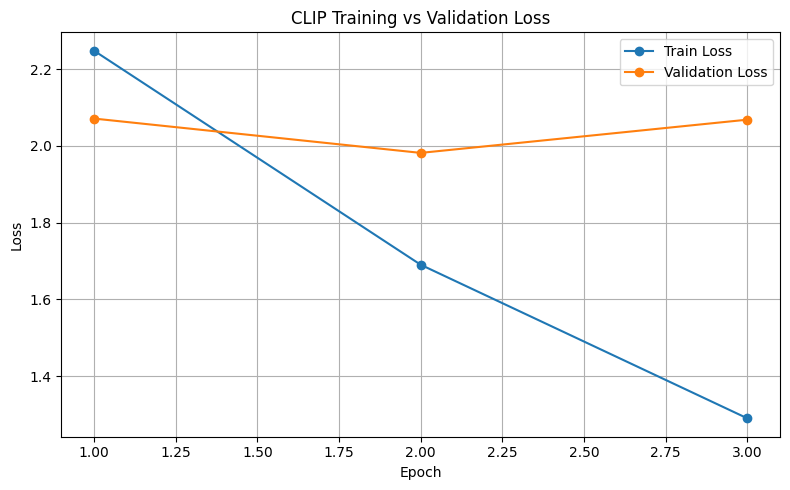

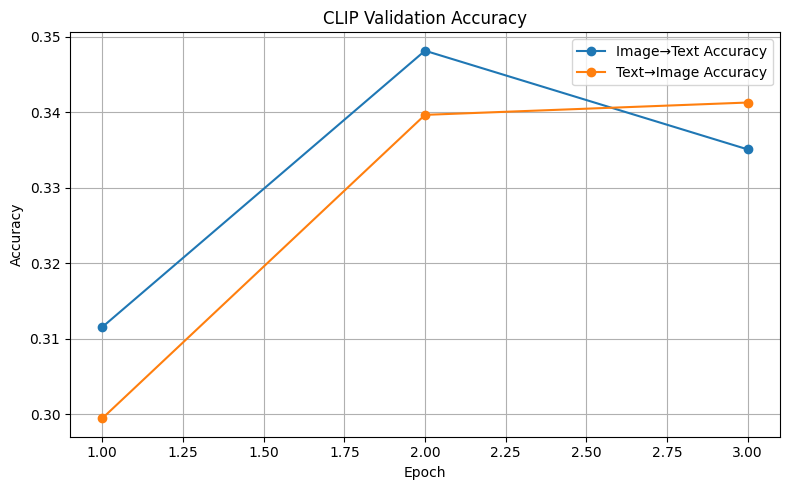

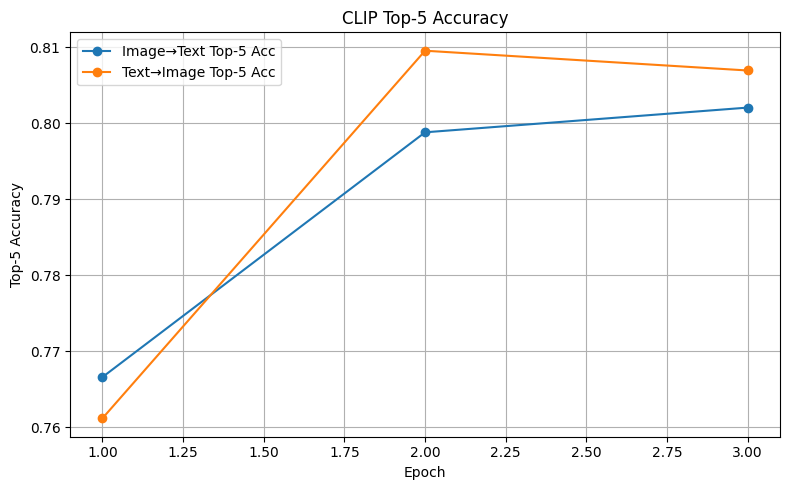

In [66]:
import matplotlib.pyplot as plt

# Plot Train and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["train_loss"], label="Train Loss", marker='o')
plt.plot(metrics_df["epoch"], metrics_df["val_loss"], label="Validation Loss", marker='o')
plt.title("CLIP Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation Accuracy (Image-to-Text & Text-to-Image)
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["image_to_text_acc"], label="Image→Text Accuracy", marker='o')
plt.plot(metrics_df["epoch"], metrics_df["text_to_image_acc"], label="Text→Image Accuracy", marker='o')
plt.title("CLIP Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Top-5 Accuracies
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["image_to_text_top5"], label="Image→Text Top-5 Acc", marker='o')
plt.plot(metrics_df["epoch"], metrics_df["text_to_image_top5"], label="Text→Image Top-5 Acc", marker='o')
plt.title("CLIP Top-5 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
# import matplotlib.pyplot as plt

# plt.plot(train_losses, label="Train Loss")
# plt.plot(val_losses, label="Val Loss")
# plt.title("CLIP Fine-Tuning Loss")
# plt.legend()
# plt.show()

# plt.plot(val_accuracies, label="Val Accuracy")
# plt.title("CLIP Val Accuracy")
# plt.legend()
# plt.show()


In [68]:
# import sys
# import os
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# from scripts.datset import ProcessedCLIPDataset

# ds = ProcessedCLIPDataset("texts/train.json", "images/")
# img = ds[0]["image"]
# txt = ds[0]["text"]
# print(txt)
# img.show()


In [69]:
# Same dataset used for retrieval
retrieval_dataset = test_dataset

def image_collate_fn(batch):
    images = [item["image"] for item in batch]
    return processor(images=images, return_tensors="pt", padding=True)

def text_collate_fn(batch):
    texts = [item["text"] for item in batch]
    return processor(text=texts, return_tensors="pt", padding=True, truncation=True)

image_loader = DataLoader(retrieval_dataset, batch_size=32, shuffle=False, collate_fn=image_collate_fn)
text_loader = DataLoader(retrieval_dataset, batch_size=32, shuffle=False, collate_fn=text_collate_fn)


In [70]:
import torch.nn.functional as F

def get_top_k_retrieval(model, image_loader, text_loader, k=5, device="cuda"):
    model.eval()
    all_image_embs, all_text_embs = [], []

    with torch.no_grad():
        for batch in image_loader:
            pixel_values = batch["pixel_values"].to(device)
            image_embs = model.get_image_features(pixel_values=pixel_values)
            image_embs = F.normalize(image_embs, dim=-1)
            all_image_embs.append(image_embs)

        for batch in text_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            text_embs = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_embs = F.normalize(text_embs, dim=-1)
            all_text_embs.append(text_embs)

    all_image_embs = torch.cat(all_image_embs, dim=0)
    all_text_embs = torch.cat(all_text_embs, dim=0)

    similarity = all_image_embs @ all_text_embs.T

    topk_image_to_text = similarity.topk(k, dim=1)
    topk_text_to_image = similarity.topk(k, dim=0)

    return topk_image_to_text, topk_text_to_image


In [71]:
# Load your best model
model.load_state_dict(torch.load("best_clip_model.pt"))
model.eval().cuda()

# Compute retrieval
topk_i2t, topk_t2i = get_top_k_retrieval(model, image_loader, text_loader, k=5)


In [72]:
def compute_recall_at_k(topk_indices, k):
    correct = 0
    for i in range(len(topk_indices)):
        if i in topk_indices[i][:k]:
            correct += 1
    return correct / len(topk_indices)


In [73]:
recall_at_1 = compute_recall_at_k(topk_i2t.indices, 1)
recall_at_5 = compute_recall_at_k(topk_i2t.indices, 5)
print(f"Recall@1: {recall_at_1:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")


Recall@1: 0.0118
Recall@5: 0.0467


In [74]:
def compute_mrr(topk_indices):
    mrr = 0.0
    for i in range(len(topk_indices)):
        ranks = topk_indices[i].tolist()
        if i in ranks:
            rank = ranks.index(i) + 1
            mrr += 1.0 / rank
    return mrr / len(topk_indices)

mrr_score = compute_mrr(topk_i2t.indices)
print(f"MRR: {mrr_score:.4f}")


MRR: 0.0231


In [75]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_image_to_text(idx, hf_dataset, topk_indices):
    image = hf_dataset[idx]["image"]
    top_text_indices = topk_indices[idx].cpu().tolist()

    plt.imshow(image)
    plt.axis('off')
    plt.title("Query Image")
    plt.show()

    print("Top-5 Retrieved Captions:")
    for rank, text_idx in enumerate(top_text_indices):
        print(f"{rank+1}: {hf_dataset[text_idx]['impression']}")


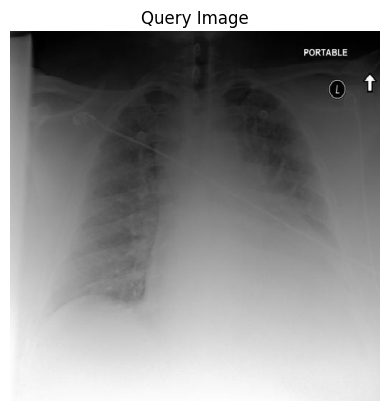

Top-5 Retrieved Captions:


KeyError: 'impression'

In [76]:
visualize_image_to_text(0, test_dataset, topk_i2t.indices)


In [ ]:
torch.save(all_image_embs, "image_embs.pt")
torch.save(all_text_embs, "text_embs.pt")
import numpy as np
np.save("image_embs.npy", all_image_embs.cpu().numpy())
np.save("text_embs.npy", all_text_embs.cpu().numpy())
